In [1]:
from __future__ import division
import numpy as np
import scipy as sp
from scipy.integrate import odeint
from scipy import stats
from scipy import interpolate
from scipy.integrate import solve_ivp
import math
import matplotlib.pyplot as plt
import pandas as pd # to read excel
print(f"pandas version is {pd.__version__}")
import seaborn as sns
from array import *
import researchpy as rp
import scipy.stats as stats
%matplotlib inline

from myfunctions_offshore import *

import datetime

pandas version is 1.0.1


In [2]:
# 1. Indoor system
#   a. Read data and parameters from excel file

xl = pd.ExcelFile('C:/Users/meiro/Desktop/GitHub/Model/Meiron_model/data/Parameters.xlsx')
x2 = pd.ExcelFile('C:/Users/meiro/Desktop/GitHub/Model/Meiron_model/data/Data.xlsx')

# Import parameters into df1
df1 = xl.parse('Parameters')

# assigmment of parameters to values: 
for key,val in zip(df1.Parameter,df1.Indoor_value):
    exec(key + '=val')
    print(key,val)

umol_to_percent_DW 0.0014
n_days 7.0
Duration 7.0
Nint0 1.85
m0 0.15
Nintcrit 4.5
miu 0.04
Nintmax 5.5
Nintmin 0.48
Ks 14.0
Vmax 60.0
Z 0.178
KI 35.0
K0 0.5
Ka 0.05
Topt 18.0
Tmin 5.0
Tmax 35.0
n 5.0
losses20 0.0016
teta 1.047
Sopt 25.0
Smin 3.0
Smax 48.0
Shigh 30.0
Slow 12.0
KN 1.1
dNextoutdt 0.014
dNextindt 0.0
dmoutdt 0.0
Next00  4032.0
dilution 0.0


In [3]:
#Re-calibrate after sample 80 is reanalysed 

In [4]:
# parameters for minimum combined error:
miu = 0.033 #0.04
losses20 = 0.003 # 0.004
Nintmax = 4.2 #4.25
Nintcrit = 3.9 #3.9 #3.5 
Ks = 15.5 #25.8 #15.5
Vmax = 199 #199 #150 #199
KI = 78 #15.2 - outdoor the irradiance is high?
K0 = 2.4 #2.1
Ka = 0.123 #0.12 #0.075
Smin = 7.75 #0 #2.5 #5
Sopt = 27 #28 #34
Smax = 44.2 #45
Topt = 20.6 #21.9 # 20.6
Tmax = 36.5 #35.9 # 36.5
n = 5.1
Tmin = 5

In [5]:
# parameters for minimum combined error - multiscale:
miu = 0.04 #0.046
losses20 = 0.004 #0.005
Nintmax = 4.5 #4.25
Nintcrit = 2 #2 #3.7
dNextoutdt = 0.01 #0 #0.04
Ks = 15.5 #25.8 #14 #24.8
Vmax = 50 #53 # low because of nitrate
KI = 16 #15.2 #18 #20 #139
K0 = 2.4 #1.5 #1.7
Ka = 0.12 #0.15 #0.127
Smin = 0 #2.5
Sopt = 28 #18
Smax = 50 #45
Topt = 18 #18 #22.2  #21.9 #18
Tmax = 35.9 #34.4
n = 5.1 #2
Tmin = 4

In [6]:
miu = 0.03
#miu = X[0]
lossess20 = 0.004
Nintmax = 4.5
Nintcrit = 2.3 #2
dNextoutdt = 0.015 #0.01
Ks = 20#23 #15.5
Vmax = 50
KI = 16
K0 = 2 #2.4
Ka = 0.1 #0.085 #0.07 #0.12
Smin = 0
Sopt = 28
Smax = 50
Topt = 18
Tmax = 35.9
n = 5.1

In [7]:
# 3. Offshore system - data:
#   a. Read data and parameters
# Import offshore data into df4
df4 = x2.parse('Offshore')

In [8]:
df4

,Sample,Exp,Period,Cage,Depth,Stage,Days,Timei,Timeh,Timem,...,NO3,dN,TN,DGR,RGR,GR,Treatment,Comment,Comment 2,N_Saturation
0,1.00,1,Continuous,1,1,i,NaN,"2019,5,20,09,0","2019,5,20,09,0","2019,5,20,09,0",...,NaN,NaN,7.110000,NaN,NaN,NaN,NaN,NaN,NaN,no
1,2.00,1,Continuous,2,1,i,NaN,"2019,5,20,09,0","2019,5,20,09,0","2019,5,20,09,0",...,NaN,NaN,7.110000,NaN,NaN,NaN,NaN,NaN,NaN,no
2,3.00,1,Continuous,3,1,i,NaN,"2019,5,20,09,0","2019,5,20,09,0","2019,5,20,09,0",...,NaN,NaN,7.110000,NaN,NaN,NaN,NaN,NaN,NaN,no
3,4.00,1,Continuous,4,1,i,NaN,"2019,5,20,09,0","2019,5,20,09,0","2019,5,20,09,0",...,NaN,NaN,7.110000,NaN,NaN,NaN,NaN,NaN,NaN,no
4,5.00,1,Continuous,5,1,i,NaN,"2019,5,20,09,0","2019,5,20,09,0","2019,5,20,09,0",...,NaN,NaN,7.110000,NaN,NaN,NaN,NaN,NaN,NaN,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,140.12,5,Continuous,20,5,f,NaN,"2020,04,30,11,0","2020,04,30,11,0","2020,05,8,0,0",...,NaN,0.256732,0.157342,0.185417,NaN,10.249715,NaN,NaN,NaN,no
172,141.12,5,Continuous,21,5,f,NaN,"2020,04,30,11,0","2020,04,30,11,0","2020,05,8,0,0",...,NaN,NaN,NaN,0.172500,NaN,9.798110,NaN,NaN,NaN,no
173,142.12,5,Continuous,22,5,f,NaN,"2020,04,30,11,0","2020,04,30,11,0","2020,05,8,0,0",...,NaN,NaN,NaN,0.150000,NaN,8.959015,NaN,NaN,NaN,no
174,143.12,5,Continuous,23,5,f,NaN,"2020,04,30,11,0","2020,04,30,11,0","2020,05,8,0,0",...,NaN,0.466493,0.133223,0.177917,NaN,9.989981,NaN,NaN,NaN,no


In [9]:
T = []
for i in df4['Sample'][:]:
    T1 = df4['Timeh'][df4['Sample'].values.tolist().index(i)]
    T2 = df4['Time'][df4['Sample'].values.tolist().index(i)]
    T.append(Time_to_Hours(T1,T2))
    
df4.loc[:,'T'] = T

Tm = []
for i in df4['Sample'][:]:
    T1 = df4['Timem'][df4['Sample'].values.tolist().index(i)]
    T2 = df4['Time'][df4['Sample'].values.tolist().index(i)]
    Tm.append(Time_to_Hours(T1,T2))
    
df4.loc[:,'Tm'] = Tm

df4f = df4[(df4.Stage == 'f')]
df4i = df4[(df4.Stage == 'i')]
# DWi = df3i.DW
# Ni = df3i.N
#df4f = df4f.assign(DWi = df3i.DW.values)
df4f = df4f.assign(Ni = df4i.N.values)

df4Reduced = df4f[(np.isnan(df4f.DW) != True)&(df4f.Stage == 'f') & (df4f.Depth == 5) & (df4f.Exp != 1) & (df4f.Period == 'Continuous') & (df4f.Days != 12)]
df4Reduced

,Sample,Exp,Period,Cage,Depth,Stage,Days,Timei,Timeh,Timem,...,DGR,RGR,GR,Treatment,Comment,Comment 2,N_Saturation,T,Tm,Ni
62,53.70,2,Continuous,13,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.077470,6.189534,6.385100,1000 / 7 / 18,fertilization in a 35 liter container,NaN,no,170,170,1.760000
63,54.70,2,Continuous,14,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.177315,11.528773,12.219628,1000 / 7 / 18,fertilization in a 35 liter container,NaN,no,170,170,NaN
64,55.70,2,Continuous,15,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.192143,12.175506,12.947741,1000 / 7 / 18,fertilization in a 35 liter container,NaN,no,170,170,NaN
65,56.70,2,Continuous,16,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.124470,8.951807,9.364710,NaN,NaN,NaN,no,170,170,NaN
66,57.70,2,Continuous,17,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.129353,9.210430,9.647918,NaN,NaN,NaN,no,170,170,NaN
67,58.70,2,Continuous,18,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.106246,7.943142,8.267131,NaN,NaN,NaN,no,170,170,NaN
119,93.70,3,Continuous,13,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,0.069286,NaN,5.811373,NaN,NaN,NaN,no,166,166,1.193394
120,94.70,3,Continuous,14,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,0.082143,NaN,6.704550,NaN,NaN,NaN,no,166,166,NaN
121,95.70,3,Continuous,15,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,0.082143,NaN,6.704550,NaN,NaN,NaN,no,166,166,NaN
122,96.70,3,Continuous,16,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,0.067143,NaN,5.658022,NaN,NaN,NaN,no,166,166,NaN


In [10]:
# c. Build interpolations functions for temperature data

xCTD = pd.ExcelFile('C:/Users/meiro/Desktop/GitHub/Model/Meiron_model/data/CTDr.xlsx')
dfCTD = xCTD.parse('HaderaCTD',header=None)

dfCTD

,0,1,2,3,4,5,6,7,8,9,10
0,time_ISO8601 [yyyy-mm-ddThh:mm:ss:sss],Year,Month,Day,Time,Date&Time,WaterTemp [degC],Depth [m],Longitude [degrees_east],Latitude [degrees_north,Bot. Depth [m]
1,2019-07-22T00:01:03,2019,07,22,00:01:03,2019-07-22 00:01:03,29.7534,12,1,NaN,NaN
2,2019-07-22T00:11:04,2019,07,22,00:11:04,2019-07-22 00:11:04,29.6921,12,2,NaN,NaN
3,2019-07-22T00:21:03,2019,07,22,00:21:03,2019-07-22 00:21:03,29.7344,12,3,NaN,NaN
4,2019-07-22T00:31:04,2019,07,22,00:31:04,2019-07-22 00:31:04,29.6629,12,4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
42620,2020-05-12T23:11:03,2020,05,12,23:11:03,2020-05-12 23:11:03,21.6181,12,140,NaN,NaN
42621,2020-05-12T23:21:04,2020,05,12,23:21:04,2020-05-12 23:21:04,21.6203,12,141,NaN,NaN
42622,2020-05-12T23:31:03,2020,05,12,23:31:03,2020-05-12 23:31:03,21.576,12,142,NaN,NaN
42623,2020-05-12T23:41:04,2020,05,12,23:41:04,2020-05-12 23:41:04,21.6585,12,143,NaN,NaN


In [11]:
# Import water temperature data

Twater = dfCTD.iloc[1:42624:1][6].values 

# TCTD = dfCTD.iloc[1:42624:1][6]
# Twater = []
# for i in TCTD:
#     #if type(i) == int:
#     #    i = str(i)
#     Twater.append(i)#float(re.sub(r"\s+", "", i, flags=re.UNICODE)))

In [12]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [13]:
# T_average is a moving average of 1 hour with jumps of 1 hours (6 times 10 minutes)

T_average = moving_average(Twater[::6],6)


In [14]:
#plt.plot(moving_average(Twater[1::6],6),'r',alpha=.3)
#plt.plot(T_average,'b',alpha=.2)

In [15]:
# c. Build interpolations functions for temperature and light IMS data
    # 1. Import combined IMS excel for light function
dfims = pd.read_csv('C:/Users/meiro/Desktop/GitHub/Model/Meiron_model/data/ims.csv',encoding= 'unicode_escape',header=None)


# days = list(range(1,296))
days = np.arange(1,296) # or from day 0? np.arange(296)

I_plot = np.zeros(24*296)
light_hours = np.arange(5,19)
for day in days:
    for hour in light_hours:
        I_plot[(day-1)*24 + hour] = float(dfims.iloc[day][hour-1])


all_hours = np.arange(1,296*24+1)

fI0 = interpolate.interp1d(all_hours, I_plot,kind = 'linear',bounds_error=False, fill_value="extrapolate")

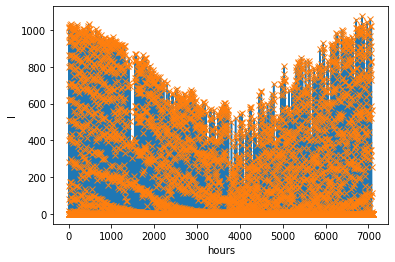

In [16]:
plt.plot(all_hours,fI0(all_hours),all_hours,I_plot,'x')
plt.xlabel('hours')
plt.ylabel('I');

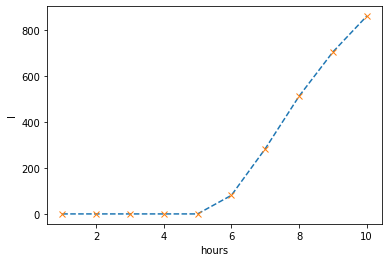

In [17]:
plt.plot(all_hours[:10],fI0(all_hours[:10]),'--',all_hours[:10],I_plot[:10],'x')
plt.xlabel('hours')
plt.ylabel('I');

In [18]:
# 4. Calculate model results for:

In [19]:
df4Reduced

,Sample,Exp,Period,Cage,Depth,Stage,Days,Timei,Timeh,Timem,...,DGR,RGR,GR,Treatment,Comment,Comment 2,N_Saturation,T,Tm,Ni
62,53.70,2,Continuous,13,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.077470,6.189534,6.385100,1000 / 7 / 18,fertilization in a 35 liter container,NaN,no,170,170,1.760000
63,54.70,2,Continuous,14,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.177315,11.528773,12.219628,1000 / 7 / 18,fertilization in a 35 liter container,NaN,no,170,170,NaN
64,55.70,2,Continuous,15,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.192143,12.175506,12.947741,1000 / 7 / 18,fertilization in a 35 liter container,NaN,no,170,170,NaN
65,56.70,2,Continuous,16,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.124470,8.951807,9.364710,NaN,NaN,NaN,no,170,170,NaN
66,57.70,2,Continuous,17,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.129353,9.210430,9.647918,NaN,NaN,NaN,no,170,170,NaN
67,58.70,2,Continuous,18,5,f,NaN,"2019,7,22,11,0","2019,7,22,11,0","2019,7,22,11,0",...,0.106246,7.943142,8.267131,NaN,NaN,NaN,no,170,170,NaN
119,93.70,3,Continuous,13,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,0.069286,NaN,5.811373,NaN,NaN,NaN,no,166,166,1.193394
120,94.70,3,Continuous,14,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,0.082143,NaN,6.704550,NaN,NaN,NaN,no,166,166,NaN
121,95.70,3,Continuous,15,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,0.082143,NaN,6.704550,NaN,NaN,NaN,no,166,166,NaN
122,96.70,3,Continuous,16,5,f,NaN,"2019,10,30,13,0","2019,10,30,13,0","2019,10,30,13,0",...,0.067143,NaN,5.658022,NaN,NaN,NaN,no,166,166,NaN


In [20]:
miu = 0.03
#miu = X[0]
lossess20 = 0.004
Nintmax = 4.5
Nintcrit = 1.7 #2.3 #2
#dNextoutdt = 0.015 #0.01
Ks = 23 #15.5
Vmax = 60
KI = 16
K0 = 0.5 #2 #2.4
Ka = 0.1 #0.085 #0.07 #0.12
Smin = 0
Sopt = 28
Smax = 50
Topt = 18
Tmax = 35.9
n = 5.1

In [21]:
#Offshore plots - reverse calculate Next values, without winter experiment (Losses due to storm)

mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
mSRE3, NintSRE3 = [], []
mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]
Y1, Y2 = [],[]
Experiments = [2,3,5]
xlabels_all = [['22 July','26 July', '29 July'],['30 Oct','3 Nov', '6 Nov'],['30 Apr', '6 May','12 May'],]

Next_0_range = [0,0.3,0.6,0.9,1.2,1.5,1.8,2.1,2.4,2.7,3,3.3,3.6,3.9,4.2,4.5,4.8,5.1,5.4,5.7,6,6.3,6.6,6.9,7.2,7.5,7.8]
#Next_0_all = []
m_0 = (20 / 1.44) * 0.15
Nint_0_all = [1.76, 1.19, 1.88]
VA = 1.44 / (0.3 * 0.15) # units: [g DW/ m^2] # A = w*l - conversion from volumetric to areal units
Z = 5 # m - depth of cages in water

for i in Experiments:
    All_RMSREm3,All_RMSRENint3 = [],[]
    for k in Next_0_range:
        mSRE3Exp,NintSRE3Exp = [],[]
        Next_0 = k
        DATA = []
        xlabels = xlabels_all[Experiments.index(i)]
        #print('\nExperiment: #' + str(i) + '\n')

        df4Temp = df4Reduced[(df4Reduced.Exp == i)] 
        Samples = df4Temp.Sample.values
        Nint_0 = Nint_0_all[Experiments.index(i)]
        #Next_0 = Next_0_all[i-2]

        t = np.arange(df4Temp['T'].values[0])
        T1 = '2019,07,22,0,0'
        T2 = df4Temp['Timei']
        T2 = T2.tolist()[0]
        t0 = Time_to_Hours(T1,T2)

        # light function
        I_reduced = I_plot[t0:t0+t[-1]+1]
        #print(I_reduced)
        fI0 = interpolate.interp1d(t, I_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")

        # T function
        T_reduced = T_average[t0:t0+t[-1]+1] 
        #print(T_reduced)

        fTemp0 = interpolate.interp1d(t, T_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")

        NEXT, NINT, M, TT = [],[],[],[]
        x0 = [Next_0,Nint_0,m_0]  

        # model simulation

        # setup initial conditions

        x = odeint(Offshore_constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                               Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))

        NEXT.append(x[: , 0]) #
        NINT.append(x[: , 1]) #
        M.append(x[: , 2])    #
        TT.append(t)

        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)


        mmod_all.append(m_model[-1])
        #print('Initial Nint is: ' + str(round(Nint_0,3)))
        #print('Initial biomass: ' + str(round(m_0,3)))
        #print('Modeled biomass for Exp ' + str(i) + ': ' + str(round(float(mmod_all[-1]),3)))
        Nintmod_all.append(Nint_model[-1])

        mexp_Temp,Nintexp_Temp = [],[]
        for j in Samples:

            #print('\nSample: #' + str(math.floor(j)))
            mexp = df4Temp[df4Temp.Sample == j].DW
            mexp = mexp.tolist()[0]
            mexp_Temp.append(mexp)
            Nintexp = df4Temp[df4Temp.Sample == j].N
            Nintexp = Nintexp.tolist()[0]
            Nintexp_Temp.append(Nintexp)
            #print('Measured biomass: ' + str(round(mexp,3)))
            #print('Measured Nint: ' + str(round(Nintexp,3)) + "\n")      

            mSRE3Exp.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
            NintSRE3Exp.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)       

        data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
        DATA.append(data)


        mSRE3All.append(mSRE3Exp)
        NintSRE3All.append(NintSRE3Exp)
        #mSRE3Exp,NintSRE3Exp = [],[]
    

        RMSREm3 = round((np.mean(mSRE3Exp))**0.5,3)
        cleanedNintSRE3 = [x for x in NintSRE3Exp if str(x) != 'nan']
        #print(cleanedNintSRE3)
        RMSRENint3 = round((np.mean(cleanedNintSRE3))**0.5,3)
        All_RMSREm3.append(RMSREm3)
        All_RMSRENint3.append(RMSRENint3)
    Y1.append(All_RMSREm3)
    Y2.append(All_RMSRENint3)
    print(i)

#RMSRENint2 = round((np.mean(cleanedNintSRE2))**0.5,3)
#print('\nThe RMSRE of m in the offshore system is: ' + str(RMSREm3))
#print('The RMSRE of Nint in the offshore system is: ' + str(RMSRENint3))

2
3
5


In [22]:
# find Next by minimum total error
a, b = [],[]
c = [1,2,4]
for i in c:
    a = Y1[c.index(i)]
    b = Y2[c.index(i)]
    #print(a)
    Y3 = []
    for j in range(len(a)):
        #if a[j] < 0.6 and b[j] < 0.6:
        Y3.append(a[j]+b[j])
        #else:
        #    Y3.append(5)
        
    #merror_best = Y1[Y1.index(min(Y3[i-1]))]
    #print(Y3)
    print(min(Y3))
    #print(min(Y2))
    print('Next for run: ' +str(i) + ' is: ' + str(Next_0_range[Y3.index(min(Y3))]))
    print('m error is: ' + str(a[Y3.index(min(Y3))]) + ' Nint error is: ' + str(b[Y3.index(min(Y3))]) + '\n')
    #print(min(Y2[i-1]))

0.415
Next for run: 1 is: 2.1
m error is: 0.288 Nint error is: 0.127

0.18
Next for run: 2 is: 2.7
m error is: 0.056 Nint error is: 0.124

0.537
Next for run: 4 is: 6
m error is: 0.463 Nint error is: 0.074




Experiment: #2

Initial Nint is: 1.76
Initial biomass: 2.083
Modeled biomass for Exp 2: 3.291
Modeled Nint for Exp 2: 0.927
Modeled Next: 2.1


Sample: #53
Measured biomass: 3.229
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.0
The Sqaure Relative Error for Nint is: nan

Sample: #54
Measured biomass: 4.646
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.17
The Sqaure Relative Error for Nint is: nan

Sample: #55
Measured biomass: 4.885
Measured Nint: 0.902

The Sqaure Relative Error for biomass is: 0.235
The Sqaure Relative Error for Nint is: 0.001

Sample: #56
Measured biomass: 3.937
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.039
The Sqaure Relative Error for Nint is: nan

Sample: #57
Measured biomass: 3.99
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.045
The Sqaure Relative Error for Nint is: nan

Sample: #58
Measured biomass: 3.615
Measured Nint: 0.762

The Sqaure Relative Error for biomass is: 0.01
The Sqaure

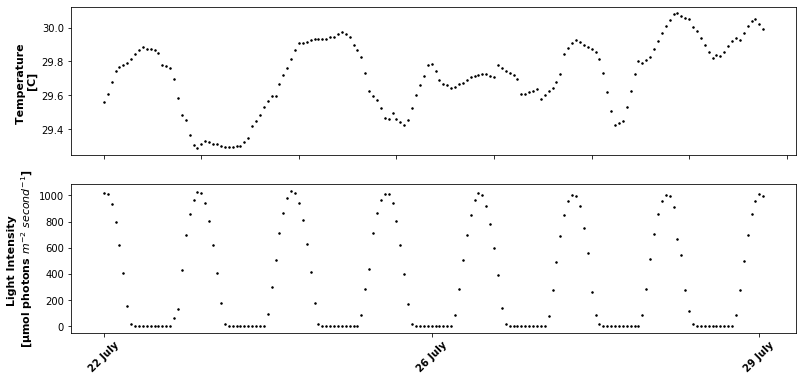

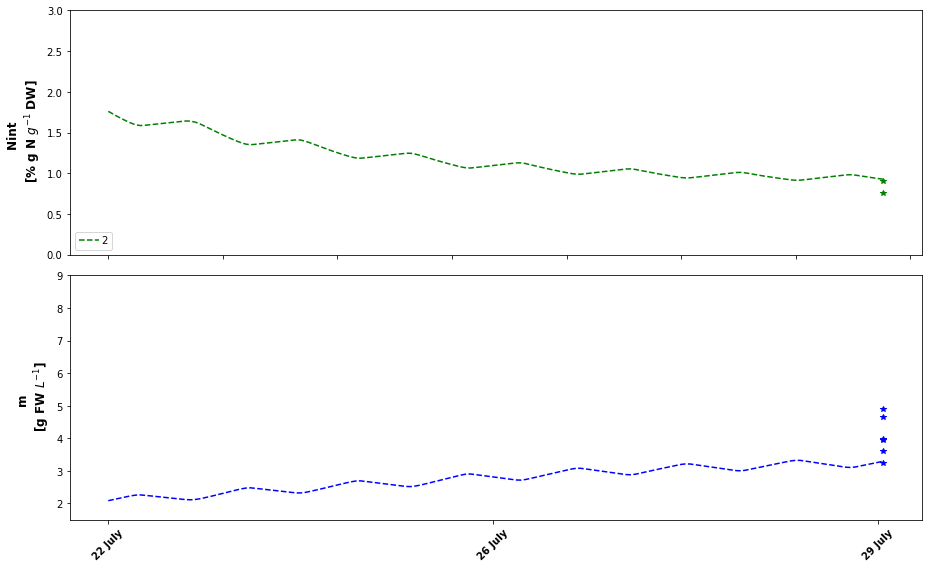

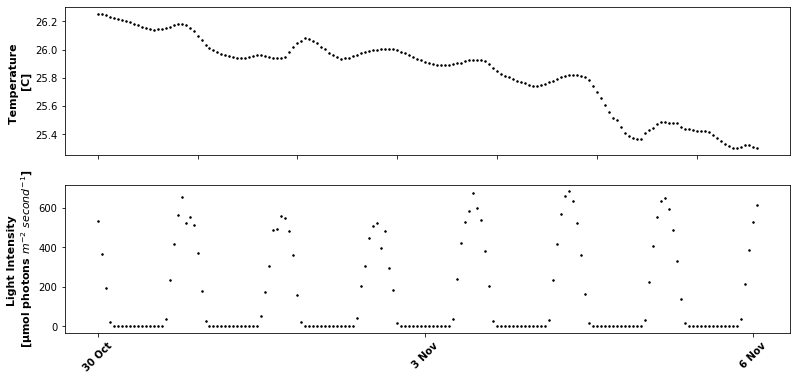

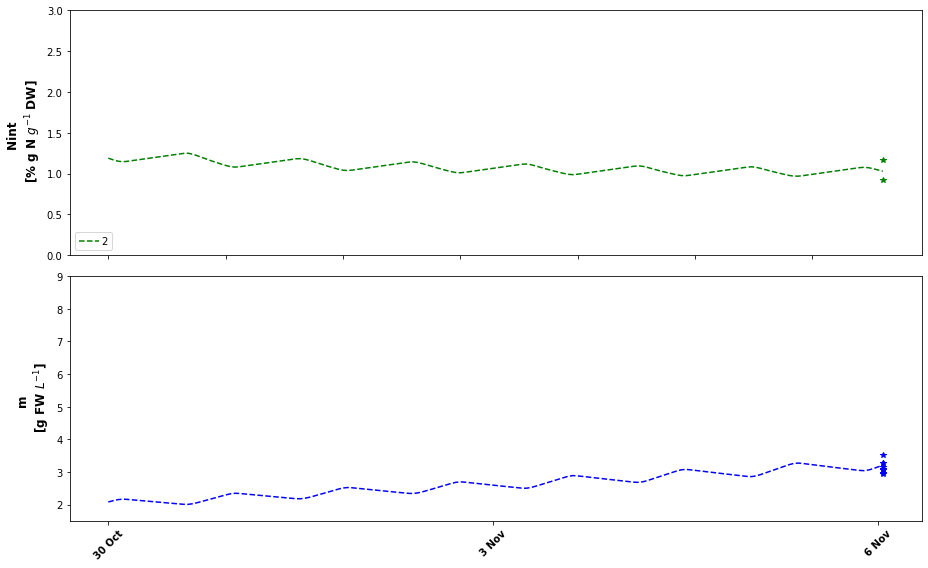

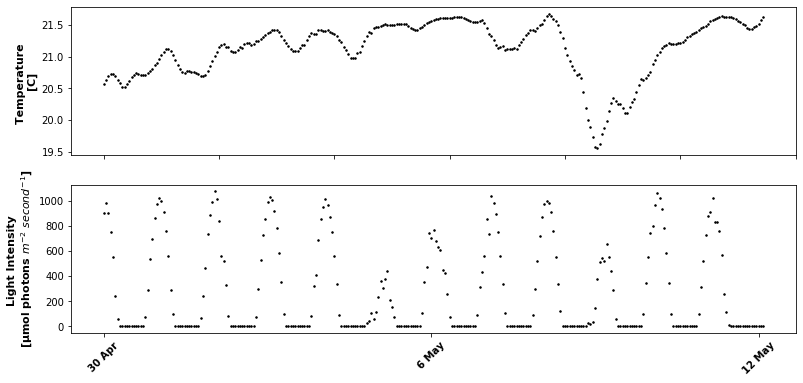

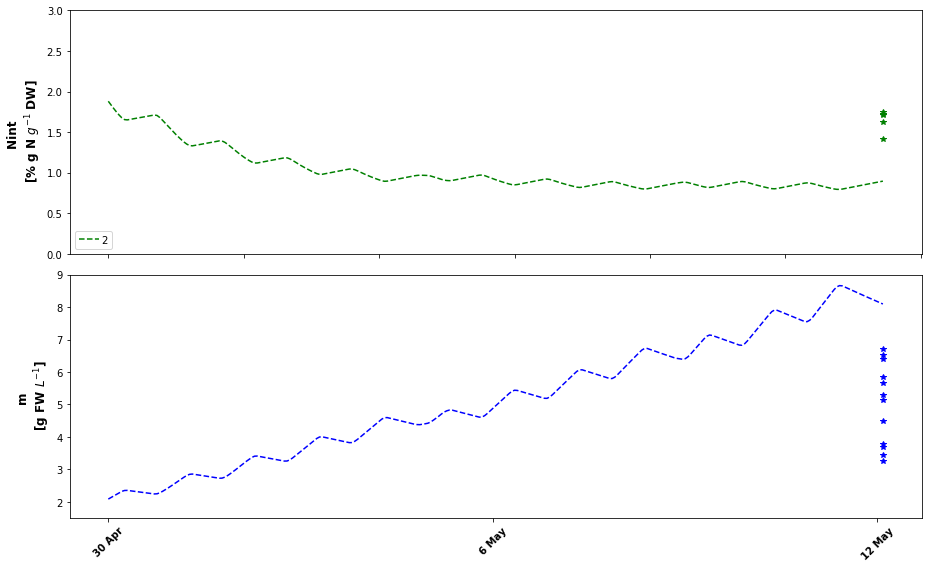

In [23]:
#Offshore plots - without winter exp

mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
mSRE3, NintSRE3 = [], []
mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]

Experiments = [2,3,5]
xlabels_all = [['22 July','26 July', '29 July'],['30 Oct','3 Nov', '6 Nov'],['30 Apr', '6 May','12 May']]


Next_0_all = [2.1,2.7,2.1]#2.7]
#Next_0 = 0.8

m_0 = (20 / 1.44) * 0.15
Nint_0_all = [1.76, 1.19, 1.88] #two last experiments waiting for real data
VA = 1.44 / (0.3 * 0.15) # units: [g DW/ m^2] # A = w*l - conversion from volumetric to areal units
Z = 5 # m - depth of cages in water
for i in Experiments:
    DATA = []
    xlabels = xlabels_all[Experiments.index(i)]
    print('\nExperiment: #' + str(i) + '\n')

    df4Temp = df4Reduced[(df4Reduced.Exp == i)] 
    Samples = df4Temp.Sample.values
    Nint_0 = Nint_0_all[Experiments.index(i)]
    Next_0 = Next_0_all[Experiments.index(i)]
    
    t = np.arange(df4Temp['T'].values[0])
    T1 = '2019,07,22,0,0'
    T2 = df4Temp['Timei']
    T2 = T2.tolist()[0]
    t0 = Time_to_Hours(T1,T2)

    # light function
    I_reduced = I_plot[t0:t0+t[-1]+1]
    #print(I_reduced)
    fI0 = interpolate.interp1d(t, I_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    # T function
    T_reduced = T_average[t0:t0+t[-1]+1] 
    #print(T_reduced)

    fTemp0 = interpolate.interp1d(t, T_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    NEXT, NINT, M, TT = [],[],[],[]
    x0 = [Next_0,Nint_0,m_0]  
    
    # model simulation

    # setup initial conditions

    x = odeint(Offshore_constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                           Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))
        
    NEXT.append(x[: , 0]) #
    NINT.append(x[: , 1]) #
    M.append(x[: , 2])    #
    TT.append(t)

    t_model = np.hstack(TT)
    Next_model = np.hstack(NEXT)
    Nint_model = np.hstack(NINT)
    m_model = np.hstack(M)
    
    
    mmod_all.append(m_model[-1])
    print('Initial Nint is: ' + str(round(Nint_0,3)))
    print('Initial biomass: ' + str(round(m_0,3)))
    print('Modeled biomass for Exp ' + str(i) + ': ' + str(round(float(mmod_all[-1]),3)))
    Nintmod_all.append(Nint_model[-1])
    print('Modeled Nint for Exp ' + str(i) + ': ' + str(round(float(Nintmod_all[-1]),3)))
    print('Modeled Next: ' + str(round(float(Next_model[-1]),3)) + '\n')
    
    # plot I and T
    fig2, ax2 = plt.subplots(2,1,figsize=(13,6))
    ax2[0].plot(t,T_reduced,'.',markersize=3,color='black')
    ax2[1].plot(t,I_reduced,'.',markersize=3,color='k')

    ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
    ax2[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")

    ax2[0].set_xticklabels([])
    ax2[1].set_xticklabels([])
    ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")
    
    # plot model
    fig, ax = plt.subplots(2,1,figsize=(13,8))
    ax[0].plot(t,NINT[-1],linestyle = '--',markersize=3.5,color='green')
    ax[0].set_ylim([0,3])
    ax[1].plot(t,M[-1],linestyle = '--',markersize=3.5,color='blue')
    ax[1].set_ylim([1.5,9])
    #col = len(l)
    ax[0].legend(Experiments,loc='lower left',fontsize='medium',markerscale=2,columnspacing = 0.2,handletextpad = 0.3)#,edgecolor='white')
        
    mexp_Temp,Nintexp_Temp = [],[]
    for j in Samples:
        
        print('\nSample: #' + str(math.floor(j)))
        mexp = df4Temp[df4Temp.Sample == j].DW
        mexp = mexp.tolist()[0]
        mexp_Temp.append(mexp)
        Nintexp = df4Temp[df4Temp.Sample == j].N
        Nintexp = Nintexp.tolist()[0]
        Nintexp_Temp.append(Nintexp)
        print('Measured biomass: ' + str(round(mexp,3)))
        print('Measured Nint: ' + str(round(Nintexp,3)) + "\n")      
        
        mSRE3Exp.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
        NintSRE3Exp.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)       
        print('The Sqaure Relative Error for biomass is: ' + str(round(mSRE3Exp[-1],3)))
        print('The Sqaure Relative Error for Nint is: ' + str(round(NintSRE3Exp[-1],3)))
        ax[1].plot(t[-1],mexp,'*',markersize = 6,color='blue')
        ax[0].plot(t[-1],Nintexp,'*',markersize = 6,color='green')

    
    data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
    DATA.append(data)
    #ax[1].plot(t[-1],mexp_Temp[k-1][j],'*',markersize = 6,color=color)
    #ax[0].plot(t[-1],Nintexp_Temp[k-1][j],'*',markersize = 6,color=color)
    
    ax[0].set_xticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

    ax[0].set_ylabel('Nint \n [% g N $g^{-1}$ DW]',fontsize=12, weight="bold")
    ax[1].set_ylabel('m \n [g FW $L^{-1}$]',fontsize=12, weight="bold")

    plt.tight_layout()
    
mSRE3All.append(mSRE3Exp)
NintSRE3All.append(NintSRE3Exp)
#mSRE3Exp,NintSRE3Exp = [],[]
    

RMSREm3 = round((np.mean(mSRE3All))**0.5,3)
cleanedNintSRE3 = [x for x in NintSRE3All[0] if str(x) != 'nan']
#print(cleanedNintSRE3)
RMSRENint3 = round((np.mean(cleanedNintSRE3))**0.5,3)


#RMSRENint2 = round((np.mean(cleanedNintSRE2))**0.5,3)
print('\nThe RMSRE of m in the offshore system is: ' + str(RMSREm3))
print('The RMSRE of Nint in the offshore system is: ' + str(RMSRENint3))

In [24]:
#Offshore plots - reverse calculate Next values for exp #4, starting May 8

mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
mSRE3, NintSRE3 = [], []
mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]
Y1, Y2 = [],[]
Experiments = [5]
xlabels_all = [['8 May', '10 May','12 May']]

Next_0_range = [0,0.3,0.6,0.9,1.2,1.5,1.8,2.1,2.4,2.7,3,3.3,3.6,3.9,4.2,4.5,4.8,5.1,5.4,5.7,6,6.3,6.6,6.9,7.2,7.5,7.8]
#Next_0_all = []
m_0 = 6
Nint_0_all = [Nintmin]
VA = 1.44 / (0.3 * 0.15) * 2 # units: [g DW/ m^2] # A = w*l - conversion from volumetric to areal units (VA*2 because of wave effect)
Z = 5 # m - depth of cages in water

for i in Experiments:
    All_RMSREm3,All_RMSRENint3 = [],[]
    for k in Next_0_range:
        mSRE3Exp,NintSRE3Exp = [],[]
        Next_0 = k
        DATA = []
        xlabels = xlabels_all[0]
        #print('\nExperiment: #' + str(i) + '\n')

        df4Temp = df4Reduced[(df4Reduced.Exp == i)] 
        Samples = df4Temp.Sample.values
        Nint_0 = 0.8#Nint_0_all[0]
        #Next_0 = Next_0_all[i-2]

        t = np.arange(df4Temp['Tm'].values[0])

        T1 = '2019,07,22,0,0'
        T2 = df4Temp['Timem']
        T2 = T2.tolist()[0]
        t0 = Time_to_Hours(T1,T2)

        # light function
        I_reduced = I_plot[t0:t0+t[-1]+1]

        #print(I_reduced)
        fI0 = interpolate.interp1d(t, I_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")

        # T function
        T_reduced = T_average[t0:t0+t[-1]+1] 
        #print(T_reduced)

        fTemp0 = interpolate.interp1d(t, T_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")

        NEXT, NINT, M, TT = [],[],[],[]
        x0 = [Next_0,Nint_0,m_0]  

        # model simulation

        # setup initial conditions

        x = odeint(Offshore_constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                               Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))

        NEXT.append(x[: , 0]) #
        NINT.append(x[: , 1]) #
        M.append(x[: , 2])    #
        TT.append(t)

        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)


        mmod_all.append(m_model[-1])
        #print('Initial Nint is: ' + str(round(Nint_0,3)))
        #print('Initial biomass: ' + str(round(m_0,3)))
        #print('Modeled biomass for Exp ' + str(i) + ': ' + str(round(float(mmod_all[-1]),3)))
        Nintmod_all.append(Nint_model[-1])
        #print('Modeled Nint for Exp ' + str(i) + ': ' + str(round(float(Nintmod_all[-1]),3)))
        #print('Modeled Next: ' + str(round(float(Next_model[-1]),3)) + '\n')

        # plot I and T
        #fig2, ax2 = plt.subplots(2,1,figsize=(13,6))
        #ax2[0].plot(t,T_reduced,'.',markersize=3,color='black')
        #ax2[1].plot(t,I_reduced,'.',markersize=3,color='k')

        #ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
        #ax2[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")

        #ax2[0].set_xticklabels([])
        #ax2[1].set_xticklabels([])
        #ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
        #ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

        # plot model
        #fig, ax = plt.subplots(2,1,figsize=(13,8))
        #ax[0].plot(t,NINT[-1],linestyle = '--',markersize=3.5,color='green')
        #ax[0].set_ylim([0.5,5.5])
        #ax[1].plot(t,M[-1],linestyle = '--',markersize=3.5,color='blue')

        #col = len(l)
        #ax[0].legend(Experiments,loc='lower left',fontsize='medium',markerscale=2,columnspacing = 0.2,handletextpad = 0.3)#,edgecolor='white')

        mexp_Temp,Nintexp_Temp = [],[]
        for j in Samples:

            #print('\nSample: #' + str(math.floor(j)))
            mexp = df4Temp[df4Temp.Sample == j].DW
            mexp = mexp.tolist()[0]
            mexp_Temp.append(mexp)
            Nintexp = df4Temp[df4Temp.Sample == j].N
            Nintexp = Nintexp.tolist()[0]
            Nintexp_Temp.append(Nintexp)
            #print('Measured biomass: ' + str(round(mexp,3)))
            #print('Measured Nint: ' + str(round(Nintexp,3)) + "\n")      

            mSRE3Exp.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
            NintSRE3Exp.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)       
            #print('The Sqaure Relative Error for biomass is: ' + str(round(mSRE3Exp[-1],3)))
            #print('The Sqaure Relative Error for Nint is: ' + str(round(NintSRE3Exp[-1],3)))
            #ax[1].plot(t[-1],mexp,'*',markersize = 6,color='blue')
            #ax[0].plot(t[-1],Nintexp,'*',markersize = 6,color='green')


        data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
        DATA.append(data)
        #ax[1].plot(t[-1],mexp_Temp[k-1][j],'*',markersize = 6,color=color)
        #ax[0].plot(t[-1],Nintexp_Temp[k-1][j],'*',markersize = 6,color=color)

        #ax[0].set_xticklabels([])
        #ax[1].set_xticklabels([])
        #ax[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
        #ax[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

        #ax[0].set_ylabel('Nint \n [% g N $g DW^{-1}$]',fontsize=12, weight="bold")
        #ax[1].set_ylabel('m \n [g FW $l^{-1}$]',fontsize=12, weight="bold")

        #plt.tight_layout()

        mSRE3All.append(mSRE3Exp)
        NintSRE3All.append(NintSRE3Exp)
        #mSRE3Exp,NintSRE3Exp = [],[]
    

        RMSREm3 = round((np.mean(mSRE3Exp))**0.5,3)
        cleanedNintSRE3 = [x for x in NintSRE3Exp if str(x) != 'nan']
        #print(cleanedNintSRE3)
        RMSRENint3 = round((np.mean(cleanedNintSRE3))**0.5,3)
        All_RMSREm3.append(RMSREm3)
        All_RMSRENint3.append(RMSRENint3)
    Y1.append(All_RMSREm3)
    Y2.append(All_RMSRENint3)
    print(i)

#RMSRENint2 = round((np.mean(cleanedNintSRE2))**0.5,3)
#print('\nThe RMSRE of m in the offshore system is: ' + str(RMSREm3))
#print('The RMSRE of Nint in the offshore system is: ' + str(RMSRENint3))

5


In [25]:
# find Next by minimum total error
a, b = [],[]
c = [4]
for i in c:
    a = Y1[c.index(i)]
    b = Y2[c.index(i)]
    #print(a)
    Y3 = []
    for j in range(len(a)):
        #if a[j] < 0.6 and b[j] < 0.6:
        Y3.append(a[j]+b[j])
        #else:
        #    Y3.append(5)
        
    #merror_best = Y1[Y1.index(min(Y3[i-1]))]
    #print(Y3)
    print(min(Y3))
    #print(min(Y2))
    print('Next for run: ' +str(i) + ' is: ' + str(Next_0_range[Y3.index(min(Y3))]))
    print('m error is: ' + str(a[Y3.index(min(Y3))]) + ' Nint error is: ' + str(b[Y3.index(min(Y3))]) + '\n')
    #print(min(Y2[i-1]))

0.417
Next for run: 4 is: 6.6
m error is: 0.344 Nint error is: 0.073




Experiment: #5

Initial Nint is: 0.8
Initial biomass: 6
Modeled biomass for Exp 5: 7.167
Modeled Nint for Exp 5: 1.642
Modeled Next: 6.6


Sample: #133
Measured biomass: 3.427
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.272
The Sqaure Relative Error for Nint is: nan

Sample: #134
Measured biomass: 4.479
Measured Nint: 1.742

The Sqaure Relative Error for biomass is: 0.141
The Sqaure Relative Error for Nint is: 0.004

Sample: #135
Measured biomass: 5.146
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.08
The Sqaure Relative Error for Nint is: nan

Sample: #136
Measured biomass: 5.281
Measured Nint: 1.718

The Sqaure Relative Error for biomass is: 0.069
The Sqaure Relative Error for Nint is: 0.002

Sample: #137
Measured biomass: 3.781
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.223
The Sqaure Relative Error for Nint is: nan

Sample: #138
Measured biomass: 3.25
Measured Nint: 1.715

The Sqaure Relative Error for biomass is: 0.299
Th

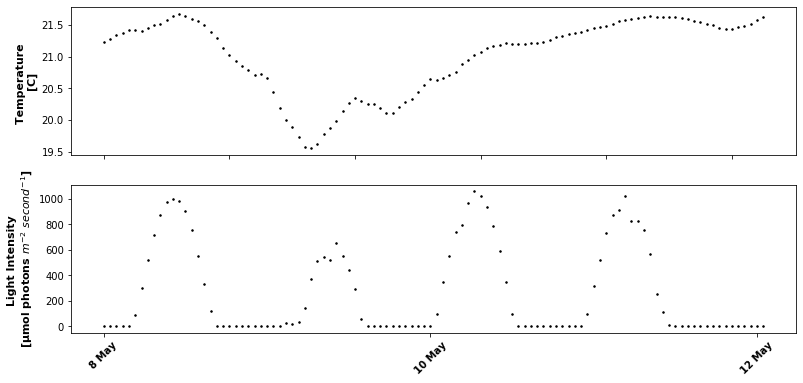

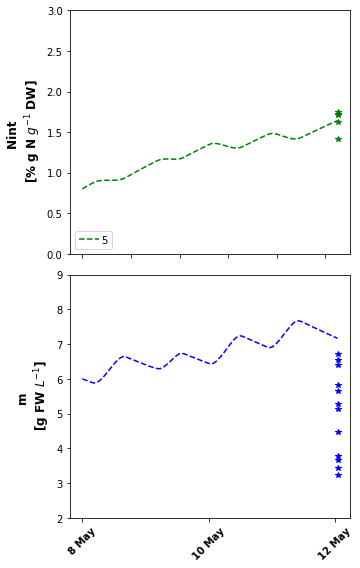

In [26]:
#Offshore plots -   exp #5
#Ka = 0.12

mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
mSRE3, NintSRE3 = [], []
mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]

Experiments = [5]
xlabels_all = [['8 May', '10 May','12 May']]


Next_0_all = [6.6]#2.7]
#Next_0 = 0.8

m_0 = 6
Nint_0_all = [0.8] #two last experiments waiting for real data
VA = 1.44 / (0.3 * 0.15) * 2 # units: [g DW/ m^2] # A = w*l - conversion from volumetric to areal units
Z = 5 # m - depth of cages in water
for i in Experiments:
    DATA = []
    xlabels = xlabels_all[Experiments.index(i)]
    print('\nExperiment: #' + str(i) + '\n')

    df4Temp = df4Reduced[(df4Reduced.Exp == i)] 
    Samples = df4Temp.Sample.values
    Nint_0 = Nint_0_all[Experiments.index(i)]
    Next_0 = Next_0_all[Experiments.index(i)]
    
    t = np.arange(df4Temp['Tm'].values[0])
    T1 = '2019,07,22,0,0'
    T2 = df4Temp['Timem']
    T2 = T2.tolist()[0]
    t0 = Time_to_Hours(T1,T2)

    # light function
    I_reduced = I_plot[t0:t0+t[-1]+1]
    #print(I_reduced)
    fI0 = interpolate.interp1d(t, I_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    # T function
    T_reduced = T_average[t0:t0+t[-1]+1] 
    #print(T_reduced)

    fTemp0 = interpolate.interp1d(t, T_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    NEXT, NINT, M, TT = [],[],[],[]
    x0 = [Next_0,Nint_0,m_0]  
    
    # model simulation

    # setup initial conditions

    x = odeint(Offshore_constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                           Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))
        
    NEXT.append(x[: , 0]) #
    NINT.append(x[: , 1]) #
    M.append(x[: , 2])    #
    TT.append(t)

    t_model = np.hstack(TT)
    Next_model = np.hstack(NEXT)
    Nint_model = np.hstack(NINT)
    m_model = np.hstack(M)
    
    
    mmod_all.append(m_model[-1])
    print('Initial Nint is: ' + str(round(Nint_0,3)))
    print('Initial biomass: ' + str(round(m_0,3)))
    print('Modeled biomass for Exp ' + str(i) + ': ' + str(round(float(mmod_all[-1]),3)))
    Nintmod_all.append(Nint_model[-1])
    print('Modeled Nint for Exp ' + str(i) + ': ' + str(round(float(Nintmod_all[-1]),3)))
    print('Modeled Next: ' + str(round(float(Next_model[-1]),3)) + '\n')
    
    # plot I and T
    fig2, ax2 = plt.subplots(2,1,figsize=(13,6))
    ax2[0].plot(t,T_reduced,'.',markersize=3,color='black')
    ax2[1].plot(t,I_reduced,'.',markersize=3,color='k')

    ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
    ax2[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")

    ax2[0].set_xticklabels([])
    ax2[1].set_xticklabels([])
    ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")
    
    # plot model
    fig, ax = plt.subplots(2,1,figsize=(5.1,8))
    ax[0].plot(t,NINT[-1],linestyle = '--',markersize=3.5,color='green')
    ax[0].set_ylim([0.5,5.5])
    ax[1].plot(t,M[-1],linestyle = '--',markersize=3.5,color='blue')

    #col = len(l)
    ax[0].legend(Experiments,loc='lower left',fontsize='medium',markerscale=2,columnspacing = 0.2,handletextpad = 0.3)#,edgecolor='white')
        
    mexp_Temp,Nintexp_Temp = [],[]
    for j in Samples:
        
        print('\nSample: #' + str(math.floor(j)))
        mexp = df4Temp[df4Temp.Sample == j].DW
        mexp = mexp.tolist()[0]
        mexp_Temp.append(mexp)
        Nintexp = df4Temp[df4Temp.Sample == j].N
        Nintexp = Nintexp.tolist()[0]
        Nintexp_Temp.append(Nintexp)
        print('Measured biomass: ' + str(round(mexp,3)))
        print('Measured Nint: ' + str(round(Nintexp,3)) + "\n")      
        
        mSRE3Exp.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
        NintSRE3Exp.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)       
        print('The Sqaure Relative Error for biomass is: ' + str(round(mSRE3Exp[-1],3)))
        print('The Sqaure Relative Error for Nint is: ' + str(round(NintSRE3Exp[-1],3)))
        ax[1].plot(t[-1],mexp,'*',markersize = 6,color='blue')
        ax[0].plot(t[-1],Nintexp,'*',markersize = 6,color='green')

    
    data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
    DATA.append(data)
    #ax[1].plot(t[-1],mexp_Temp[k-1][j],'*',markersize = 6,color=color)
    #ax[0].plot(t[-1],Nintexp_Temp[k-1][j],'*',markersize = 6,color=color)
    
    ax[0].set_xticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

    ax[0].set_ylabel('Nint \n [% g N $g^{-1}$ DW]',fontsize=12, weight="bold")
    ax[0].set_ylim([0,3])
    ax[1].set_ylabel('m \n [g FW $L^{-1}$]',fontsize=12, weight="bold")
    ax[1].set_ylim([2,9])

    plt.tight_layout()
    
mSRE3All.append(mSRE3Exp)
NintSRE3All.append(NintSRE3Exp)
#mSRE3Exp,NintSRE3Exp = [],[]
    

RMSREm3 = round((np.mean(mSRE3All))**0.5,3)
cleanedNintSRE3 = [x for x in NintSRE3All[0] if str(x) != 'nan']
#print(cleanedNintSRE3)
RMSRENint3 = round((np.mean(cleanedNintSRE3))**0.5,3)


#RMSRENint2 = round((np.mean(cleanedNintSRE2))**0.5,3)
print('\nThe RMSRE of m in the offshore system is: ' + str(RMSREm3))
print('The RMSRE of Nint in the offshore system is: ' + str(RMSRENint3))

In [27]:
df4Temp['Timem']

164    2020,05,8,0,0
165    2020,05,8,0,0
166    2020,05,8,0,0
167    2020,05,8,0,0
168    2020,05,8,0,0
169    2020,05,8,0,0
170    2020,05,8,0,0
171    2020,05,8,0,0
172    2020,05,8,0,0
173    2020,05,8,0,0
174    2020,05,8,0,0
175    2020,05,8,0,0
Name: Timem, dtype: object


Experiment: #2

Initial Nint is: 1.76
Initial biomass: 2.083
Modeled biomass for Exp 2: 2.842
Modeled Nint for Exp 2: 0.726
Modeled Next: 0.9


Sample: #53
Measured biomass: 3.229
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.019
The Sqaure Relative Error for Nint is: nan

Sample: #54
Measured biomass: 4.646
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.403
The Sqaure Relative Error for Nint is: nan

Sample: #55
Measured biomass: 4.885
Measured Nint: 0.902

The Sqaure Relative Error for biomass is: 0.517
The Sqaure Relative Error for Nint is: 0.059

Sample: #56
Measured biomass: 3.937
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.149
The Sqaure Relative Error for Nint is: nan

Sample: #57
Measured biomass: 3.99
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.163
The Sqaure Relative Error for Nint is: nan

Sample: #58
Measured biomass: 3.615
Measured Nint: 0.762

The Sqaure Relative Error for biomass is: 0.074
The Sq

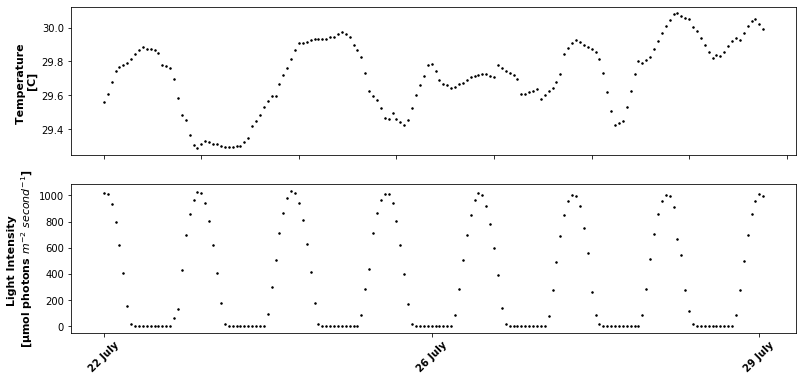

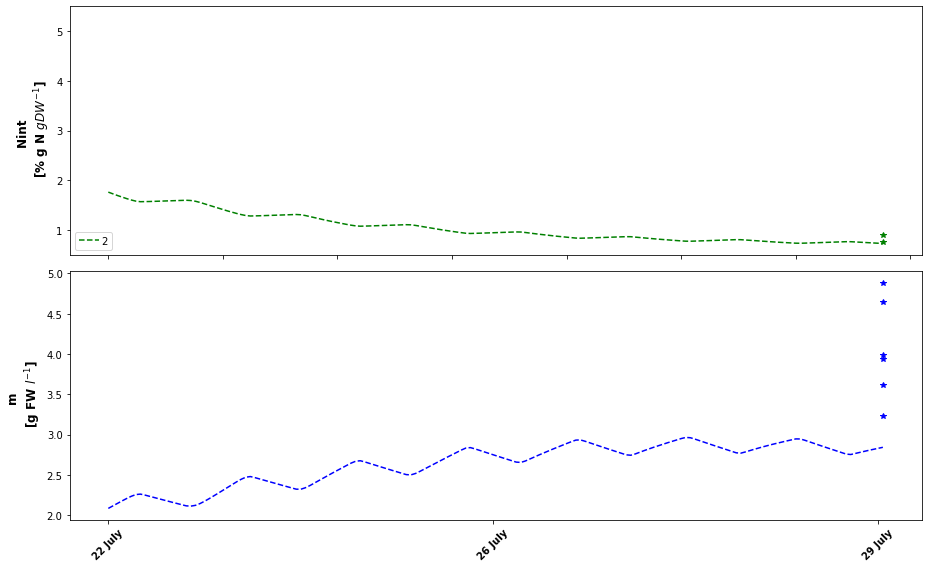

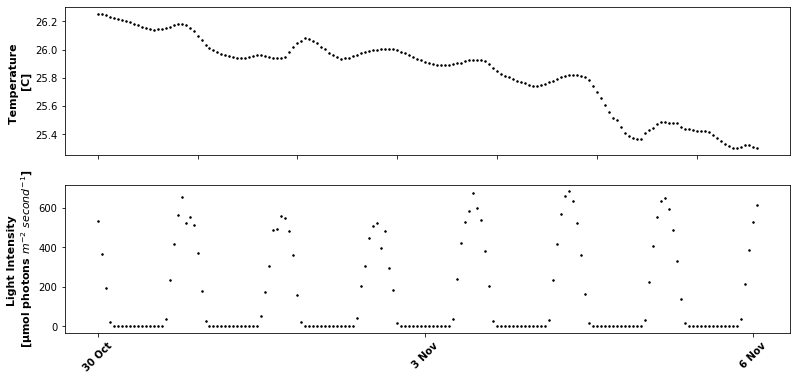

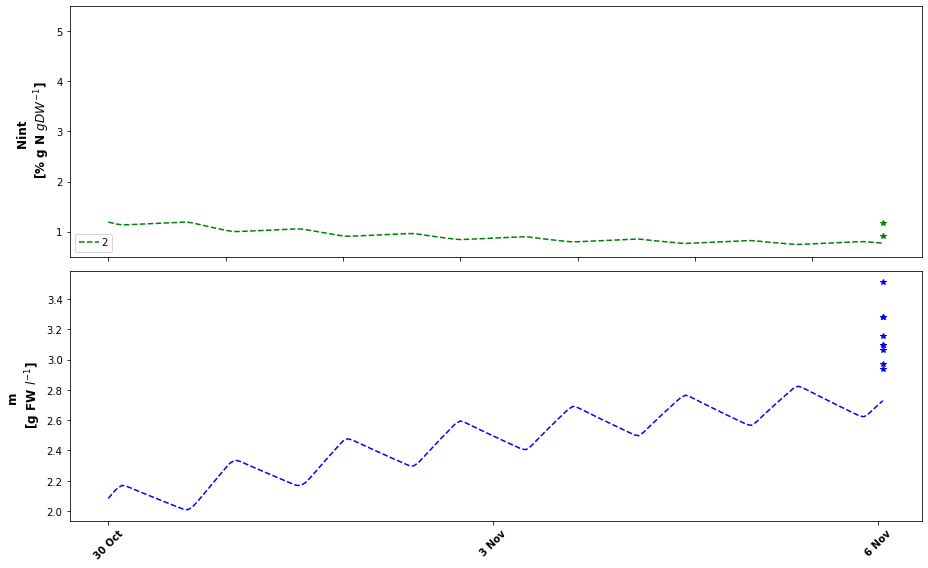

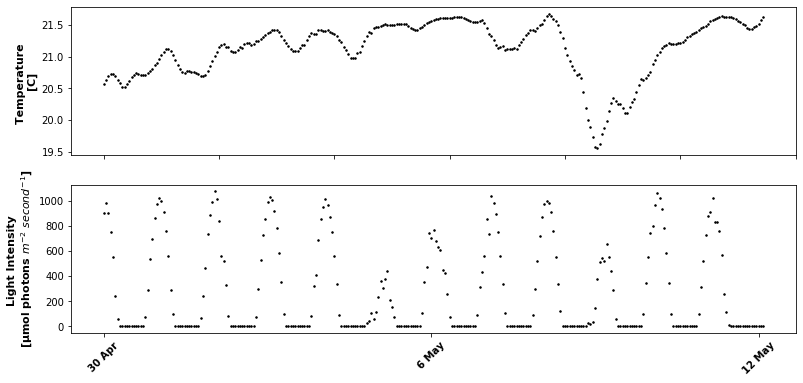

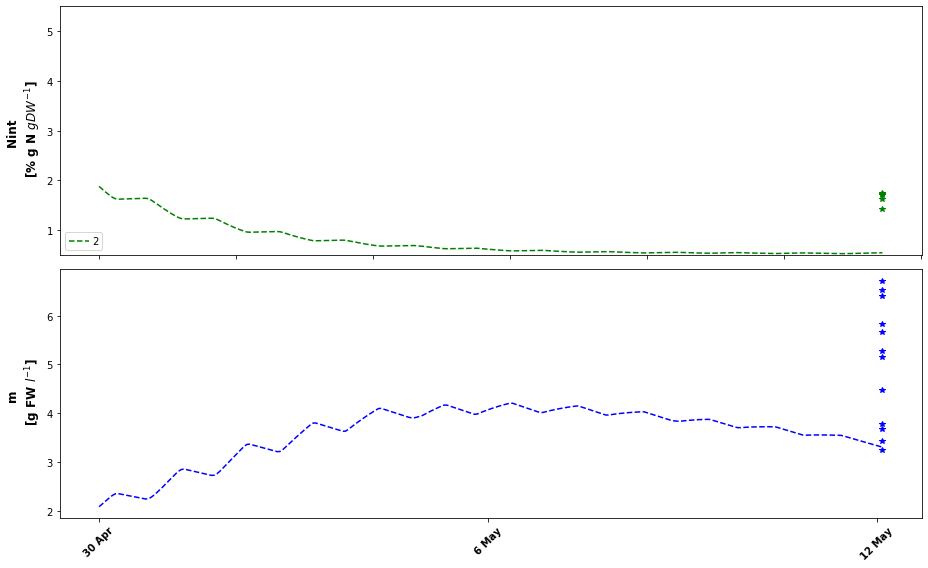

In [28]:
#Offshore plots - without winter exp

mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
mSRE3, NintSRE3 = [], []
mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]

Experiments = [2,3,5]
xlabels_all = [['22 July','26 July', '29 July'],['30 Oct','3 Nov', '6 Nov'],['30 Apr', '6 May','12 May'],]


Next_0_all = [0.9,1.2,0.3]#2.7]
#Next_0 = 0.8

m_0 = (20 / 1.44) * 0.15
Nint_0_all = [1.76, 1.19, 1.88] #two last experiments waiting for real data
VA = 1.44 / (0.3 * 0.15) # units: [g DW/ m^2] # A = w*l - conversion from volumetric to areal units
Z = 5 # m - depth of cages in water
for i in Experiments:
    DATA = []
    xlabels = xlabels_all[Experiments.index(i)]
    print('\nExperiment: #' + str(i) + '\n')

    df4Temp = df4Reduced[(df4Reduced.Exp == i)] 
    Samples = df4Temp.Sample.values
    Nint_0 = Nint_0_all[Experiments.index(i)]
    Next_0 = Next_0_all[Experiments.index(i)]
    
    t = np.arange(df4Temp['T'].values[0])
    T1 = '2019,07,22,0,0'
    T2 = df4Temp['Timei']
    T2 = T2.tolist()[0]
    t0 = Time_to_Hours(T1,T2)

    # light function
    I_reduced = I_plot[t0:t0+t[-1]+1]
    #print(I_reduced)
    fI0 = interpolate.interp1d(t, I_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    # T function
    T_reduced = T_average[t0:t0+t[-1]+1] 
    #print(T_reduced)

    fTemp0 = interpolate.interp1d(t, T_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    NEXT, NINT, M, TT = [],[],[],[]
    x0 = [Next_0,Nint_0,m_0]  
    
    # model simulation

    # setup initial conditions

    x = odeint(Offshore_constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                           Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))
        
    NEXT.append(x[: , 0]) #
    NINT.append(x[: , 1]) #
    M.append(x[: , 2])    #
    TT.append(t)

    t_model = np.hstack(TT)
    Next_model = np.hstack(NEXT)
    Nint_model = np.hstack(NINT)
    m_model = np.hstack(M)
    
    
    mmod_all.append(m_model[-1])
    print('Initial Nint is: ' + str(round(Nint_0,3)))
    print('Initial biomass: ' + str(round(m_0,3)))
    print('Modeled biomass for Exp ' + str(i) + ': ' + str(round(float(mmod_all[-1]),3)))
    Nintmod_all.append(Nint_model[-1])
    print('Modeled Nint for Exp ' + str(i) + ': ' + str(round(float(Nintmod_all[-1]),3)))
    print('Modeled Next: ' + str(round(float(Next_model[-1]),3)) + '\n')
    
    # plot I and T
    fig2, ax2 = plt.subplots(2,1,figsize=(13,6))
    ax2[0].plot(t,T_reduced,'.',markersize=3,color='black')
    ax2[1].plot(t,I_reduced,'.',markersize=3,color='k')

    ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
    ax2[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")

    ax2[0].set_xticklabels([])
    ax2[1].set_xticklabels([])
    ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")
    
    # plot model
    fig, ax = plt.subplots(2,1,figsize=(13,8))
    ax[0].plot(t,NINT[-1],linestyle = '--',markersize=3.5,color='green')
    ax[0].set_ylim([0.5,5.5])
    ax[1].plot(t,M[-1],linestyle = '--',markersize=3.5,color='blue')

    #col = len(l)
    ax[0].legend(Experiments,loc='lower left',fontsize='medium',markerscale=2,columnspacing = 0.2,handletextpad = 0.3)#,edgecolor='white')
        
    mexp_Temp,Nintexp_Temp = [],[]
    for j in Samples:
        
        print('\nSample: #' + str(math.floor(j)))
        mexp = df4Temp[df4Temp.Sample == j].DW
        mexp = mexp.tolist()[0]
        mexp_Temp.append(mexp)
        Nintexp = df4Temp[df4Temp.Sample == j].N
        Nintexp = Nintexp.tolist()[0]
        Nintexp_Temp.append(Nintexp)
        print('Measured biomass: ' + str(round(mexp,3)))
        print('Measured Nint: ' + str(round(Nintexp,3)) + "\n")      
        
        mSRE3Exp.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
        NintSRE3Exp.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)       
        print('The Sqaure Relative Error for biomass is: ' + str(round(mSRE3Exp[-1],3)))
        print('The Sqaure Relative Error for Nint is: ' + str(round(NintSRE3Exp[-1],3)))
        ax[1].plot(t[-1],mexp,'*',markersize = 6,color='blue')
        ax[0].plot(t[-1],Nintexp,'*',markersize = 6,color='green')

    
    data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
    DATA.append(data)
    #ax[1].plot(t[-1],mexp_Temp[k-1][j],'*',markersize = 6,color=color)
    #ax[0].plot(t[-1],Nintexp_Temp[k-1][j],'*',markersize = 6,color=color)
    
    ax[0].set_xticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

    ax[0].set_ylabel('Nint \n [% g N $g DW^{-1}$]',fontsize=12, weight="bold")
    ax[1].set_ylabel('m \n [g FW $l^{-1}$]',fontsize=12, weight="bold")

    plt.tight_layout()
    
mSRE3All.append(mSRE3Exp)
NintSRE3All.append(NintSRE3Exp)
#mSRE3Exp,NintSRE3Exp = [],[]
    

RMSREm3 = round((np.mean(mSRE3All))**0.5,3)
cleanedNintSRE3 = [x for x in NintSRE3All[0] if str(x) != 'nan']
#print(cleanedNintSRE3)
RMSRENint3 = round((np.mean(cleanedNintSRE3))**0.5,3)


#RMSRENint2 = round((np.mean(cleanedNintSRE2))**0.5,3)
print('\nThe RMSRE of m in the offshore system is: ' + str(RMSREm3))
print('The RMSRE of Nint in the offshore system is: ' + str(RMSRENint3))


Experiment: #2

Initial Nint is: 1.76
Initial biomass: 2.083
Modeled biomass for Exp 2: 3.1
Modeled Nint for Exp 2: 0.829
Modeled Next: 1.5


Sample: #53
Measured biomass: 3.229
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.002
The Sqaure Relative Error for Nint is: nan

Sample: #54
Measured biomass: 4.646
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.249
The Sqaure Relative Error for Nint is: nan

Sample: #55
Measured biomass: 4.885
Measured Nint: 0.902

The Sqaure Relative Error for biomass is: 0.332
The Sqaure Relative Error for Nint is: 0.008

Sample: #56
Measured biomass: 3.937
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.073
The Sqaure Relative Error for Nint is: nan

Sample: #57
Measured biomass: 3.99
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.082
The Sqaure Relative Error for Nint is: nan

Sample: #58
Measured biomass: 3.615
Measured Nint: 0.762

The Sqaure Relative Error for biomass is: 0.028
The Sqau

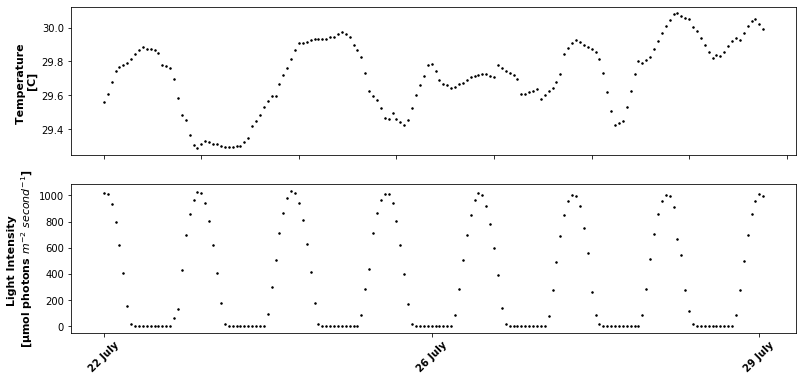

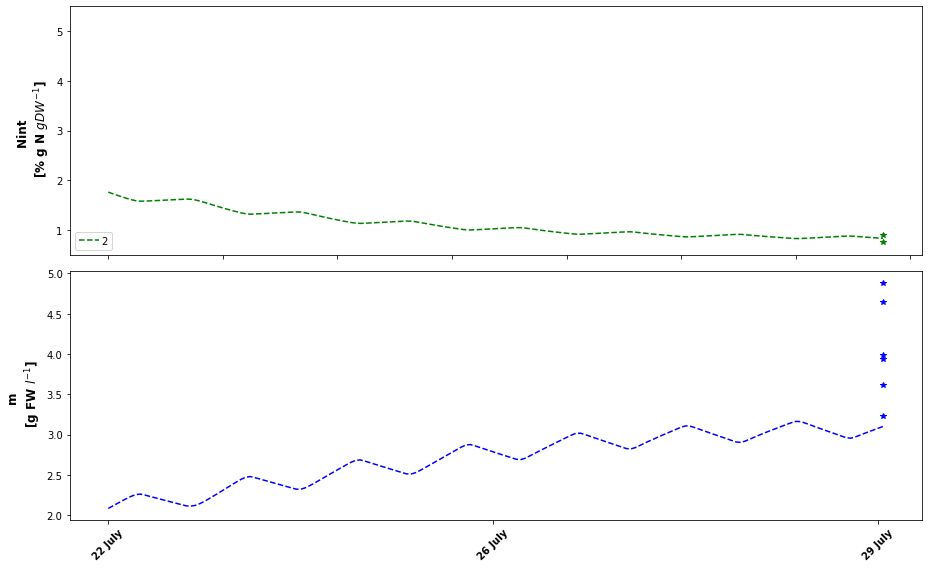

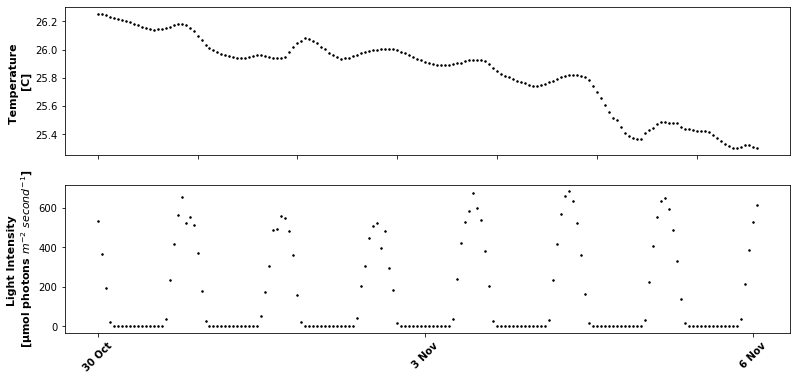

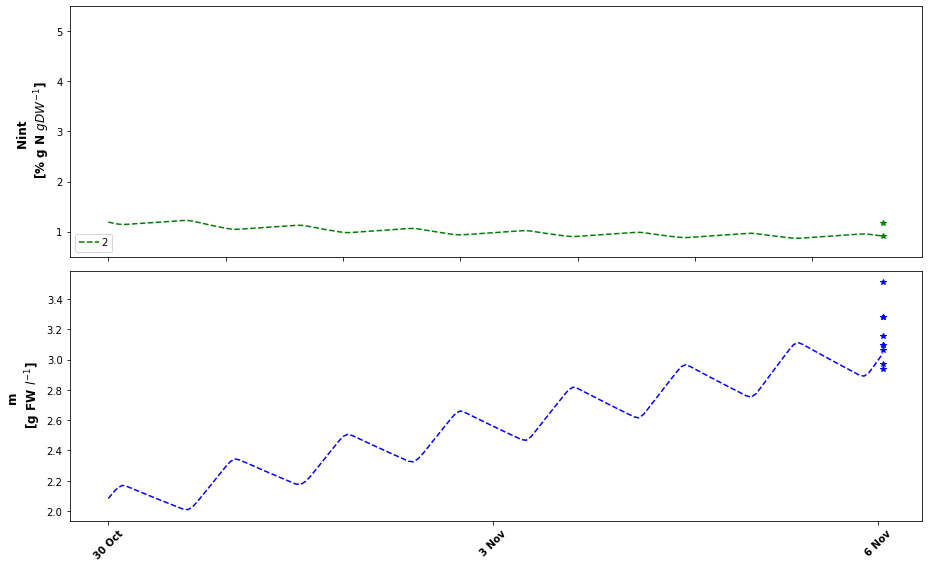

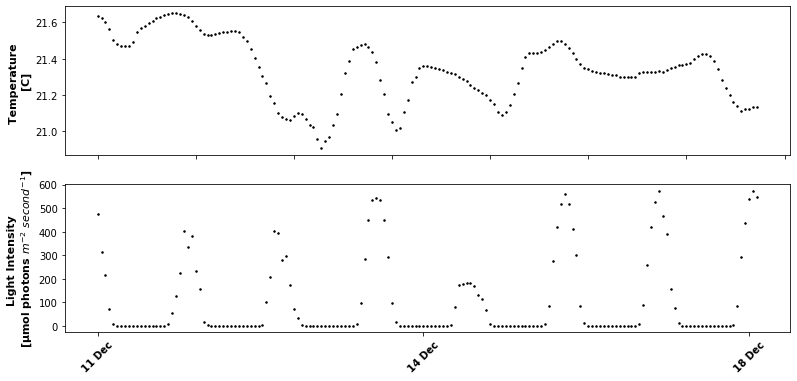

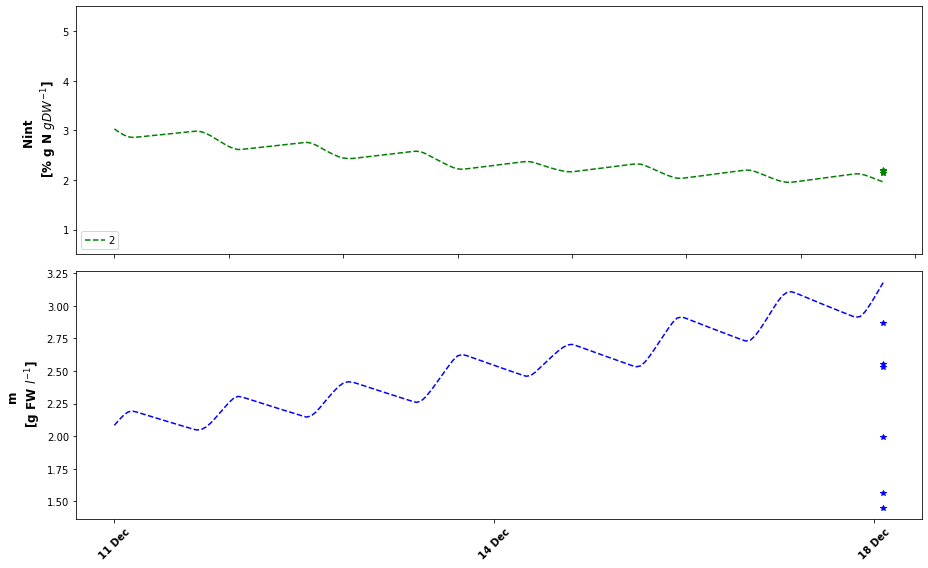

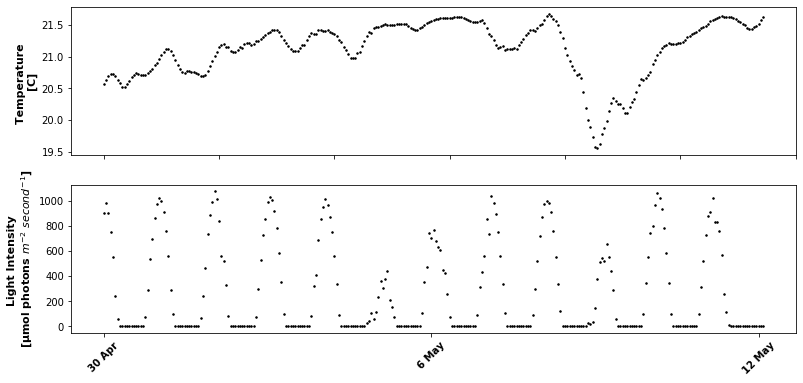

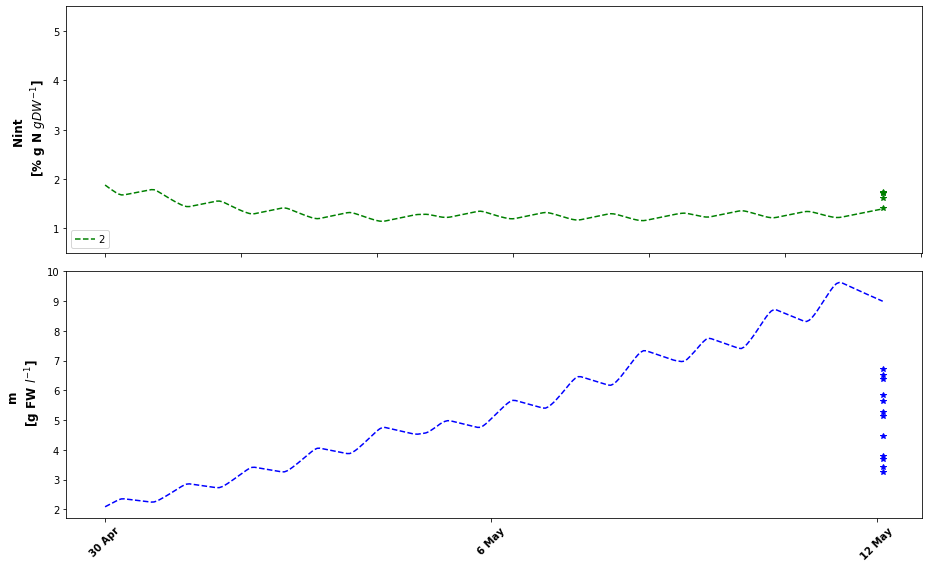

In [29]:
#Offshore plots - exp #4 till 18.12, calculated background Next

mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
mSRE3, NintSRE3 = [], []
mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]

Experiments = [2,3,4,5]
xlabels_all = [['22 July','26 July', '29 July'],['30 Oct','3 Nov', '6 Nov'],['11 Dec','14 Dec', '18 Dec'],['30 Apr', '6 May','12 May'],]


Next_0_all = [1.5,2,6.5,4.5]
#Next_0 = 0.8

m_0 = (20 / 1.44) * 0.15
Nint_0_all = [1.76, 1.19, 3.03, 1.88] #two last experiments waiting for real data
VA = 1.44 / (0.3 * 0.15) # units: [g DW/ m^2] # A = w*l - conversion from volumetric to areal units
Z = 5 # m - depth of cages in water
for i in Experiments:
    DATA = []
    xlabels = xlabels_all[i-2]
    print('\nExperiment: #' + str(i) + '\n')

    df4Temp = df4Reduced[(df4Reduced.Exp == i)] 
    Samples = df4Temp.Sample.values
    Nint_0 = Nint_0_all[i-2]
    Next_0 = Next_0_all[i-2]
    
    t = np.arange(df4Temp['T'].values[0])
    T1 = '2019,07,22,0,0'
    T2 = df4Temp['Timei']
    T2 = T2.tolist()[0]
    t0 = Time_to_Hours(T1,T2)

    # light function
    I_reduced = I_plot[t0:t0+t[-1]+1]
    #print(I_reduced)
    fI0 = interpolate.interp1d(t, I_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    # T function
    T_reduced = T_average[t0:t0+t[-1]+1] 
    #print(T_reduced)

    fTemp0 = interpolate.interp1d(t, T_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    NEXT, NINT, M, TT = [],[],[],[]
    x0 = [Next_0,Nint_0,m_0]  
    
    # model simulation

    # setup initial conditions

    x = odeint(Offshore_constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                           Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))
        
    NEXT.append(x[: , 0]) #
    NINT.append(x[: , 1]) #
    M.append(x[: , 2])    #
    TT.append(t)

    t_model = np.hstack(TT)
    Next_model = np.hstack(NEXT)
    Nint_model = np.hstack(NINT)
    m_model = np.hstack(M)
    
    
    mmod_all.append(m_model[-1])
    print('Initial Nint is: ' + str(round(Nint_0,3)))
    print('Initial biomass: ' + str(round(m_0,3)))
    print('Modeled biomass for Exp ' + str(i) + ': ' + str(round(float(mmod_all[-1]),3)))
    Nintmod_all.append(Nint_model[-1])
    print('Modeled Nint for Exp ' + str(i) + ': ' + str(round(float(Nintmod_all[-1]),3)))
    print('Modeled Next: ' + str(round(float(Next_model[-1]),3)) + '\n')
    
    # plot I and T
    fig2, ax2 = plt.subplots(2,1,figsize=(13,6))
    ax2[0].plot(t,T_reduced,'.',markersize=3,color='black')
    ax2[1].plot(t,I_reduced,'.',markersize=3,color='k')

    ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
    ax2[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")

    ax2[0].set_xticklabels([])
    ax2[1].set_xticklabels([])
    ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")
    
    # plot model
    fig, ax = plt.subplots(2,1,figsize=(13,8))
    ax[0].plot(t,NINT[-1],linestyle = '--',markersize=3.5,color='green')
    ax[0].set_ylim([0.5,5.5])
    ax[1].plot(t,M[-1],linestyle = '--',markersize=3.5,color='blue')

    #col = len(l)
    ax[0].legend(Experiments,loc='lower left',fontsize='medium',markerscale=2,columnspacing = 0.2,handletextpad = 0.3)#,edgecolor='white')
        
    mexp_Temp,Nintexp_Temp = [],[]
    for j in Samples:
        
        print('\nSample: #' + str(math.floor(j)))
        mexp = df4Temp[df4Temp.Sample == j].DW
        mexp = mexp.tolist()[0]
        mexp_Temp.append(mexp)
        Nintexp = df4Temp[df4Temp.Sample == j].N
        Nintexp = Nintexp.tolist()[0]
        Nintexp_Temp.append(Nintexp)
        print('Measured biomass: ' + str(round(mexp,3)))
        print('Measured Nint: ' + str(round(Nintexp,3)) + "\n")      
        
        mSRE3Exp.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
        NintSRE3Exp.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)       
        print('The Sqaure Relative Error for biomass is: ' + str(round(mSRE3Exp[-1],3)))
        print('The Sqaure Relative Error for Nint is: ' + str(round(NintSRE3Exp[-1],3)))
        ax[1].plot(t[-1],mexp,'*',markersize = 6,color='blue')
        ax[0].plot(t[-1],Nintexp,'*',markersize = 6,color='green')

    
    data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
    DATA.append(data)
    #ax[1].plot(t[-1],mexp_Temp[k-1][j],'*',markersize = 6,color=color)
    #ax[0].plot(t[-1],Nintexp_Temp[k-1][j],'*',markersize = 6,color=color)
    
    ax[0].set_xticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

    ax[0].set_ylabel('Nint \n [% g N $g DW^{-1}$]',fontsize=12, weight="bold")
    ax[1].set_ylabel('m \n [g FW $l^{-1}$]',fontsize=12, weight="bold")

    plt.tight_layout()
    
mSRE3All.append(mSRE3Exp)
NintSRE3All.append(NintSRE3Exp)
#mSRE3Exp,NintSRE3Exp = [],[]
    

RMSREm3 = round((np.mean(mSRE3All))**0.5,3)
cleanedNintSRE3 = [x for x in NintSRE3All[0] if str(x) != 'nan']
#print(cleanedNintSRE3)
RMSRENint3 = round((np.mean(cleanedNintSRE3))**0.5,3)


#RMSRENint2 = round((np.mean(cleanedNintSRE2))**0.5,3)
print('\nThe RMSRE of m in the offshore system is: ' + str(RMSREm3))
print('The RMSRE of Nint in the offshore system is: ' + str(RMSRENint3))

In [30]:
#Offshore plots - second part of exp #4 (18-23.12) - calculate concentration

df4Reduced2 = df4f[(np.isnan(df4f.DW) != True)&(df4f.Stage == 'f') & (df4f.Depth == 5) & (df4f.Exp != 1) & (df4f.Period == 'Continuous') & (df4f.Days != 7)]


mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
mSRE3, NintSRE3 = [], []
mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]
Y1, Y2 = [],[]
Experiments = [4]
xlabels_all = ['18 Dec','23 Dec']

Next_0_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]
#Next_0_all = []

m_0 = 3.109

#m_0 = (20 / 1.44) * 0.15
#Nint_0_all = [1.76, 1.19, 3.03, 1.88] - measured values for beggining of experiments
Nint_0 = 2.183

VA = 1.44 / (0.3 * 0.15) # units: [g DW/ m^2] # A = w*l - conversion from volumetric to areal units
Z = 5 # m - depth of cages in water

i = 4

#for i in Experiments:
All_RMSREm3,All_RMSRENint3 = [],[]
for k in Next_0_range:
    mSRE3Exp,NintSRE3Exp = [],[]
    Next_0 = k
    #m_0 = m_0_all[i-3]
    #print('for m0 = : ' + str(m_0) + '\n')
    DATA = []
    xlabels = xlabels_all
    #print('\nExperiment: #' + str(i) + '\n')

    df4Temp = df4Reduced2[(df4Reduced2.Exp == i)] 
    Samples = df4Temp.Sample.values
    #Nint_0 = Nint_0_all[i-3]
    #Next_0 = Next_0_all[i-2]

    t = np.arange(df4Temp['T'].values[0])
    T1 = '2019,07,22,0,0'
    T2 = df4Temp['Timem']
    T2 = T2.tolist()[0]
    t0 = Time_to_Hours(T1,T2)

    # light function
    I_reduced = I_plot[t0:t0+t[-1]+1]
    #print(I_reduced)
    fI0 = interpolate.interp1d(t, I_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")

    # T function
    T_reduced = T_average[t0:t0+t[-1]+1] 
    #print(T_reduced)

    fTemp0 = interpolate.interp1d(t, T_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")

    NEXT, NINT, M, TT = [],[],[],[]
    x0 = [Next_0,Nint_0,m_0]  

    # model simulation

    # setup initial conditions

    x = odeint(Offshore_constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                           Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))

    NEXT.append(x[: , 0]) #
    NINT.append(x[: , 1]) #
    M.append(x[: , 2])    #
    TT.append(t)

    t_model = np.hstack(TT)
    Next_model = np.hstack(NEXT)
    Nint_model = np.hstack(NINT)
    m_model = np.hstack(M)


    mmod_all.append(m_model[-1])
    #print('Initial Nint is: ' + str(round(Nint_0,3)))
    #print('Initial biomass: ' + str(round(m_0,3)))
    #print('Modeled biomass for Exp ' + str(i) + ': ' + str(round(float(mmod_all[-1]),3)))
    Nintmod_all.append(Nint_model[-1])
    #print('Modeled Nint for Exp ' + str(i) + ': ' + str(round(float(Nintmod_all[-1]),3)))
    #print('Modeled Next: ' + str(round(float(Next_model[-1]),3)) + '\n')

    # plot I and T
    #fig2, ax2 = plt.subplots(2,1,figsize=(13,6))
    #ax2[0].plot(t,T_reduced,'.',markersize=3,color='black')
    #ax2[1].plot(t,I_reduced,'.',markersize=3,color='k')

    #ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
    #ax2[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")

    #ax2[0].set_xticklabels([])
    #ax2[1].set_xticklabels([])
    #ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    #ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

    # plot model
    #fig, ax = plt.subplots(2,1,figsize=(13,8))
    #ax[0].plot(t,NINT[-1],linestyle = '--',markersize=3.5,color='green')
    #ax[0].set_ylim([0.5,5.5])
    #ax[1].plot(t,M[-1],linestyle = '--',markersize=3.5,color='blue')

    #col = len(l)
    #ax[0].legend(Experiments,loc='lower left',fontsize='medium',markerscale=2,columnspacing = 0.2,handletextpad = 0.3)#,edgecolor='white')

    mexp_Temp,Nintexp_Temp = [],[]
    for j in Samples:

        #print('\nSample: #' + str(math.floor(j)))
        mexp = df4Temp[df4Temp.Sample == j].DW
        mexp = mexp.tolist()[0]
        mexp_Temp.append(mexp)
        Nintexp = df4Temp[df4Temp.Sample == j].N
        Nintexp = Nintexp.tolist()[0]
        Nintexp_Temp.append(Nintexp)
        #print('Measured biomass: ' + str(round(mexp,3)))
        #print('Measured Nint: ' + str(round(Nintexp,3)) + "\n")      

        mSRE3Exp.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
        NintSRE3Exp.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)       
        #print('The Sqaure Relative Error for biomass is: ' + str(round(mSRE3Exp[-1],3)))
        #print('The Sqaure Relative Error for Nint is: ' + str(round(NintSRE3Exp[-1],3)))
        #ax[1].plot(t[-1],mexp,'*',markersize = 6,color='blue')
        #ax[0].plot(t[-1],Nintexp,'*',markersize = 6,color='green')


    data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
    DATA.append(data)
    #ax[1].plot(t[-1],mexp_Temp[k-1][j],'*',markersize = 6,color=color)
    #ax[0].plot(t[-1],Nintexp_Temp[k-1][j],'*',markersize = 6,color=color)

    #ax[0].set_xticklabels([])
    #ax[1].set_xticklabels([])
    #ax[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    #ax[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

    #ax[0].set_ylabel('Nint \n [% g N $g DW^{-1}$]',fontsize=12, weight="bold")
    #ax[1].set_ylabel('m \n [g FW $l^{-1}$]',fontsize=12, weight="bold")

    #plt.tight_layout()

    mSRE3All.append(mSRE3Exp)
    NintSRE3All.append(NintSRE3Exp)
    #mSRE3Exp,NintSRE3Exp = [],[]


    RMSREm3 = round((np.mean(mSRE3Exp))**0.5,3)
    cleanedNintSRE3 = [x for x in NintSRE3Exp if str(x) != 'nan']
    #print(cleanedNintSRE3)
    RMSRENint3 = round((np.mean(cleanedNintSRE3))**0.5,3)
    All_RMSREm3.append(RMSREm3)
    All_RMSRENint3.append(RMSRENint3)
Y1.append(All_RMSREm3)
Y2.append(All_RMSRENint3)
print(i)

#RMSRENint2 = round((np.mean(cleanedNintSRE2))**0.5,3)
#print('\nThe RMSRE of m in the offshore system is: ' + str(RMSREm3))
#print('The RMSRE of Nint in the offshore system is: ' + str(RMSRENint3))

4


In [31]:
# find Next by minimum total error
a, b = [],[]
for i in [4]:
    a = Y1[0]
    b = Y2[0]
    #print(a)
    Y3 = []
    #for j in range(len(a)):
        #if a[j] < 0.6 and b[j] < 0.6:
    
    for j in range(len(a)):
        Y3.append([a[j]+b[j]])
    #Y3 = a + b
    #print(a)
        #else:
        #    Y3.append(5)
    #print(len(Next_0_range))
    #print(len(a[0]))
    #print(len(b[0]))
    #merror_best = Y1[Y1.index(min(Y3[i-1]))]
    #print(Y3)
    #Y3 = Y3[0]
    print(str(min(Y3)) + '\n')
    #print(min(Y2))
    print('Next for run: ' +str(i) + ' is: ' + str(Next_0_range[Y3.index(min(Y3))]))
    print('m error is: ' + str(a[Y3.index(min(Y3))]) + ' Nint error is: ' + str(b[Y3.index(min(Y3))]) + '\n')
    #print(min(Y2[i-1]))

[0.5660000000000001]

Next for run: 4 is: 3.5
m error is: 0.445 Nint error is: 0.121




Experiment: #4

Initial Nint is: 2.183
Initial biomass: 3.109
Modeled biomass for Exp 4: 4.178
Modeled Nint for Exp 4: 1.947
Modeled Next: 6.5


Sample: #119
Measured biomass: 2.865
Measured Nint: 2.139

The Sqaure Relative Error for biomass is: 0.099
The Sqaure Relative Error for Nint is: 0.01

Sample: #120
Measured biomass: 2.552
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.151
The Sqaure Relative Error for Nint is: nan

Sample: #121
Measured biomass: 2.531
Measured Nint: 2.187

The Sqaure Relative Error for biomass is: 0.155
The Sqaure Relative Error for Nint is: 0.015

Sample: #122
Measured biomass: 1.562
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.392
The Sqaure Relative Error for Nint is: nan

Sample: #123
Measured biomass: 1.448
Measured Nint: 2.197

The Sqaure Relative Error for biomass is: 0.427
The Sqaure Relative Error for Nint is: 0.016

Sample: #124
Measured biomass: 1.99
Measured Nint: 2.138

The Sqaure Relative Error for biomass is

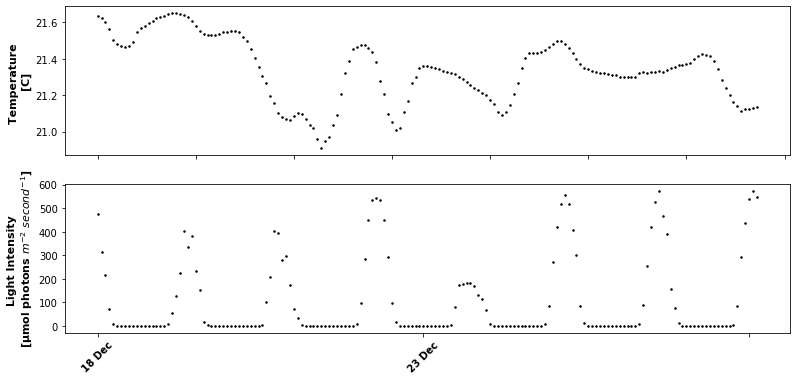

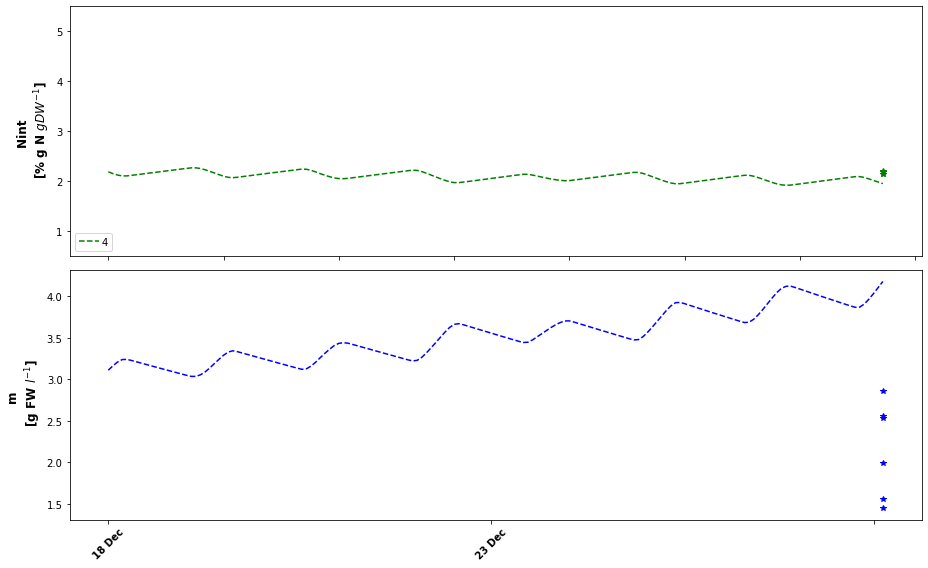

In [32]:
#Offshore plots - exp #4 till 18.12, calculated background Next

mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
mSRE3, NintSRE3 = [], []
mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]

Experiments = [4]
xlabels_all = ['18 Dec','23 Dec']


Next_0_all = [1.5,2,6.5,4.5]
#Next_0 = 0.8

m_0 = 3.109
#Nint_0_all = [1.76, 1.19, 3.03, 1.88] #two last experiments waiting for real data
VA = 1.44 / (0.3 * 0.15) # units: [g DW/ m^2] # A = w*l - conversion from volumetric to areal units
Z = 5 # m - depth of cages in water
for i in Experiments:
    DATA = []
    xlabels = xlabels_all
    print('\nExperiment: #' + str(i) + '\n')

    df4Temp = df4Reduced[(df4Reduced.Exp == i)] 
    Samples = df4Temp.Sample.values
    Nint_0 =  2.183
    #Nint_0 = Nint_0_all[i-2]
    Next_0 = Next_0_all[i-2]
    
    t = np.arange(df4Temp['T'].values[0])
    T1 = '2019,07,22,0,0'
    T2 = df4Temp['Timem']
    T2 = T2.tolist()[0]
    t0 = Time_to_Hours(T1,T2)

    # light function
    I_reduced = I_plot[t0:t0+t[-1]+1]
    #print(I_reduced)
    fI0 = interpolate.interp1d(t, I_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    # T function
    T_reduced = T_average[t0:t0+t[-1]+1] 
    #print(T_reduced)

    fTemp0 = interpolate.interp1d(t, T_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    NEXT, NINT, M, TT = [],[],[],[]
    x0 = [Next_0,Nint_0,m_0]  
    
    # model simulation

    # setup initial conditions

    x = odeint(Offshore_constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                           Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))
        
    NEXT.append(x[: , 0]) #
    NINT.append(x[: , 1]) #
    M.append(x[: , 2])    #
    TT.append(t)

    t_model = np.hstack(TT)
    Next_model = np.hstack(NEXT)
    Nint_model = np.hstack(NINT)
    m_model = np.hstack(M)
    
    
    mmod_all.append(m_model[-1])
    print('Initial Nint is: ' + str(round(Nint_0,3)))
    print('Initial biomass: ' + str(round(m_0,3)))
    print('Modeled biomass for Exp ' + str(i) + ': ' + str(round(float(mmod_all[-1]),3)))
    Nintmod_all.append(Nint_model[-1])
    print('Modeled Nint for Exp ' + str(i) + ': ' + str(round(float(Nintmod_all[-1]),3)))
    print('Modeled Next: ' + str(round(float(Next_model[-1]),3)) + '\n')
    
    # plot I and T
    fig2, ax2 = plt.subplots(2,1,figsize=(13,6))
    ax2[0].plot(t,T_reduced,'.',markersize=3,color='black')
    ax2[1].plot(t,I_reduced,'.',markersize=3,color='k')

    ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
    ax2[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")

    ax2[0].set_xticklabels([])
    ax2[1].set_xticklabels([])
    ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")
    
    # plot model
    fig, ax = plt.subplots(2,1,figsize=(13,8))
    ax[0].plot(t,NINT[-1],linestyle = '--',markersize=3.5,color='green')
    ax[0].set_ylim([0.5,5.5])
    ax[1].plot(t,M[-1],linestyle = '--',markersize=3.5,color='blue')

    #col = len(l)
    ax[0].legend(Experiments,loc='lower left',fontsize='medium',markerscale=2,columnspacing = 0.2,handletextpad = 0.3)#,edgecolor='white')
        
    mexp_Temp,Nintexp_Temp = [],[]
    for j in Samples:
        
        print('\nSample: #' + str(math.floor(j)))
        mexp = df4Temp[df4Temp.Sample == j].DW
        mexp = mexp.tolist()[0]
        mexp_Temp.append(mexp)
        Nintexp = df4Temp[df4Temp.Sample == j].N
        Nintexp = Nintexp.tolist()[0]
        Nintexp_Temp.append(Nintexp)
        print('Measured biomass: ' + str(round(mexp,3)))
        print('Measured Nint: ' + str(round(Nintexp,3)) + "\n")      
        
        mSRE3Exp.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
        NintSRE3Exp.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)       
        print('The Sqaure Relative Error for biomass is: ' + str(round(mSRE3Exp[-1],3)))
        print('The Sqaure Relative Error for Nint is: ' + str(round(NintSRE3Exp[-1],3)))
        ax[1].plot(t[-1],mexp,'*',markersize = 6,color='blue')
        ax[0].plot(t[-1],Nintexp,'*',markersize = 6,color='green')

    
    data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
    DATA.append(data)
    #ax[1].plot(t[-1],mexp_Temp[k-1][j],'*',markersize = 6,color=color)
    #ax[0].plot(t[-1],Nintexp_Temp[k-1][j],'*',markersize = 6,color=color)
    
    ax[0].set_xticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

    ax[0].set_ylabel('Nint \n [% g N $g DW^{-1}$]',fontsize=12, weight="bold")
    ax[1].set_ylabel('m \n [g FW $l^{-1}$]',fontsize=12, weight="bold")

    plt.tight_layout()
    
mSRE3All.append(mSRE3Exp)
NintSRE3All.append(NintSRE3Exp)
#mSRE3Exp,NintSRE3Exp = [],[]
    

RMSREm3 = round((np.mean(mSRE3All))**0.5,3)
cleanedNintSRE3 = [x for x in NintSRE3All[0] if str(x) != 'nan']
#print(cleanedNintSRE3)
RMSRENint3 = round((np.mean(cleanedNintSRE3))**0.5,3)


#RMSRENint2 = round((np.mean(cleanedNintSRE2))**0.5,3)
print('\nThe RMSRE of m in the offshore system is: ' + str(RMSREm3))
print('The RMSRE of Nint in the offshore system is: ' + str(RMSRENint3))


Experiment: #2

Initial Nint is: 1.76
Initial biomass: 2.083
Modeled biomass for Exp 2: 2.791
Modeled Nint for Exp 2: 0.708
Modeled Next: 0.8


Sample: #53
Measured biomass: 3.229
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.025
The Sqaure Relative Error for Nint is: nan

Sample: #54
Measured biomass: 4.646
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.442
The Sqaure Relative Error for Nint is: nan

Sample: #55
Measured biomass: 4.885
Measured Nint: 0.902

The Sqaure Relative Error for biomass is: 0.563
The Sqaure Relative Error for Nint is: 0.075

Sample: #56
Measured biomass: 3.937
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.169
The Sqaure Relative Error for Nint is: nan

Sample: #57
Measured biomass: 3.99
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.185
The Sqaure Relative Error for Nint is: nan

Sample: #58
Measured biomass: 3.615
Measured Nint: 0.762

The Sqaure Relative Error for biomass is: 0.087
The Sq

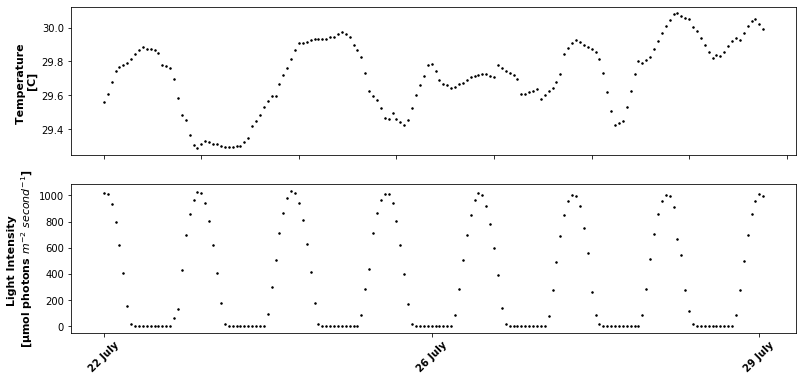

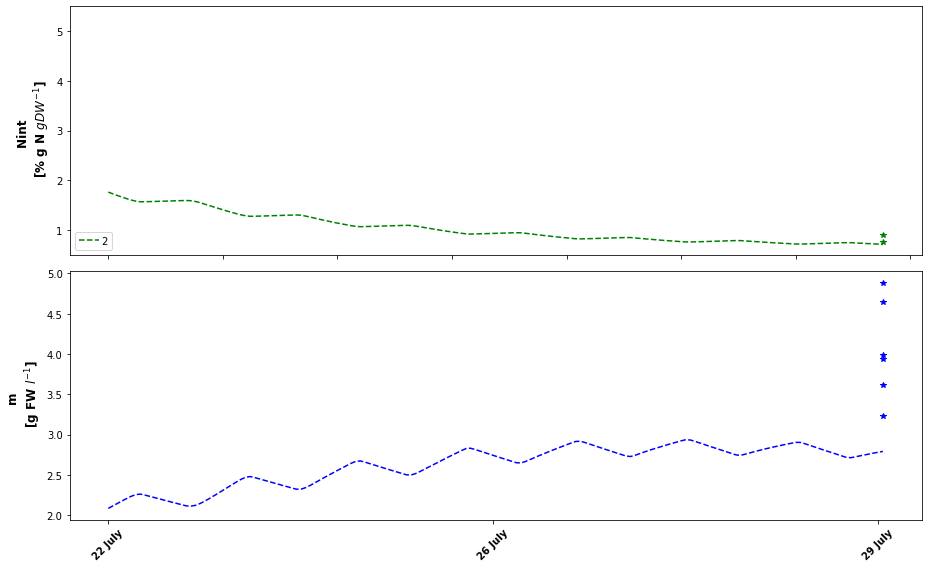

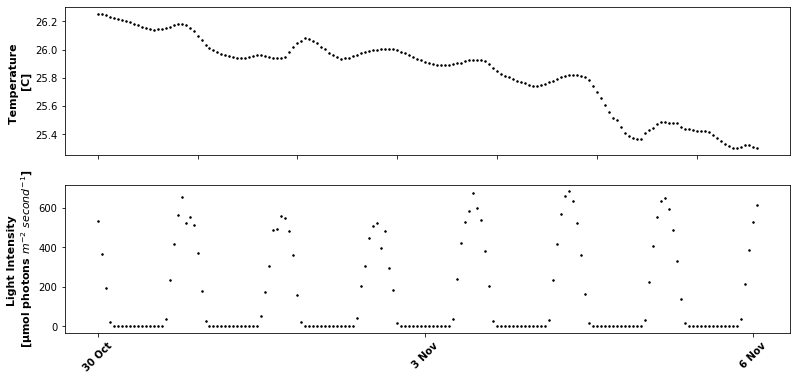

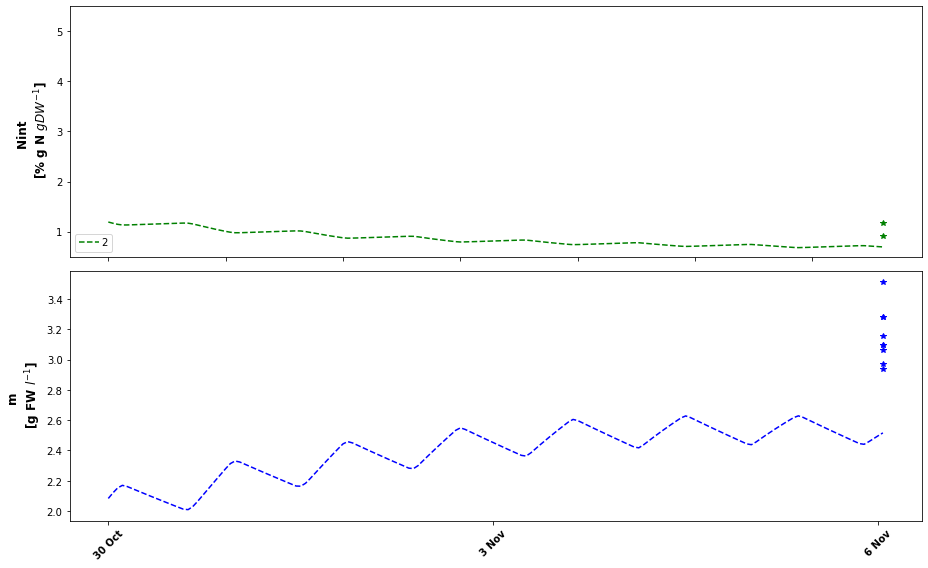

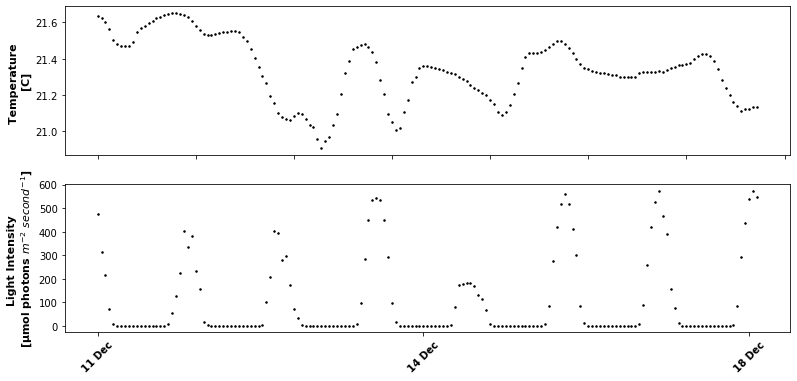

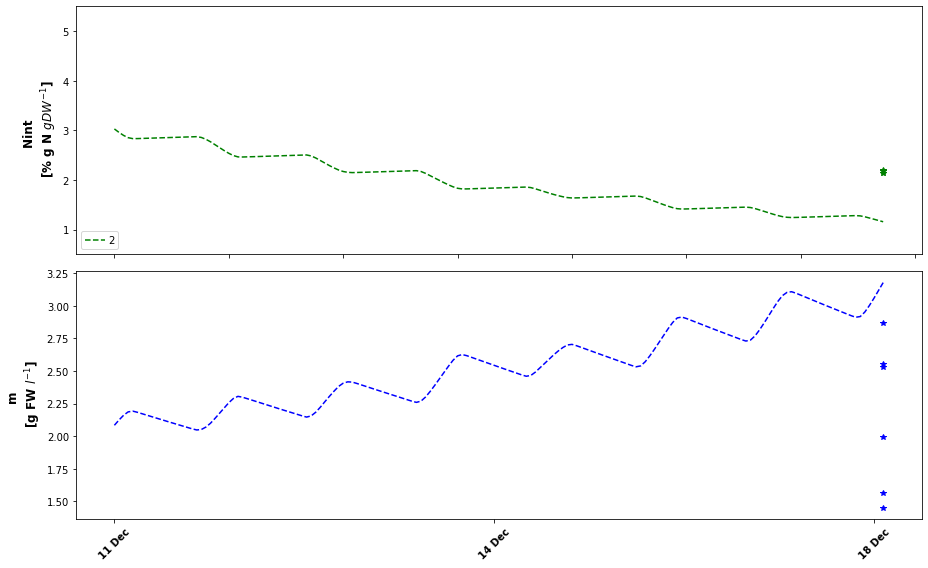

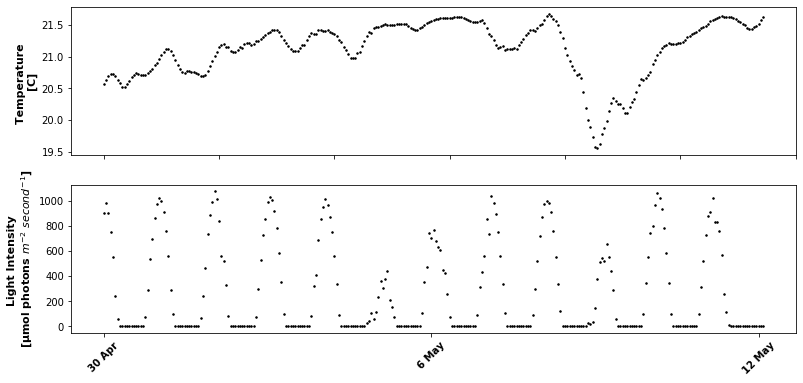

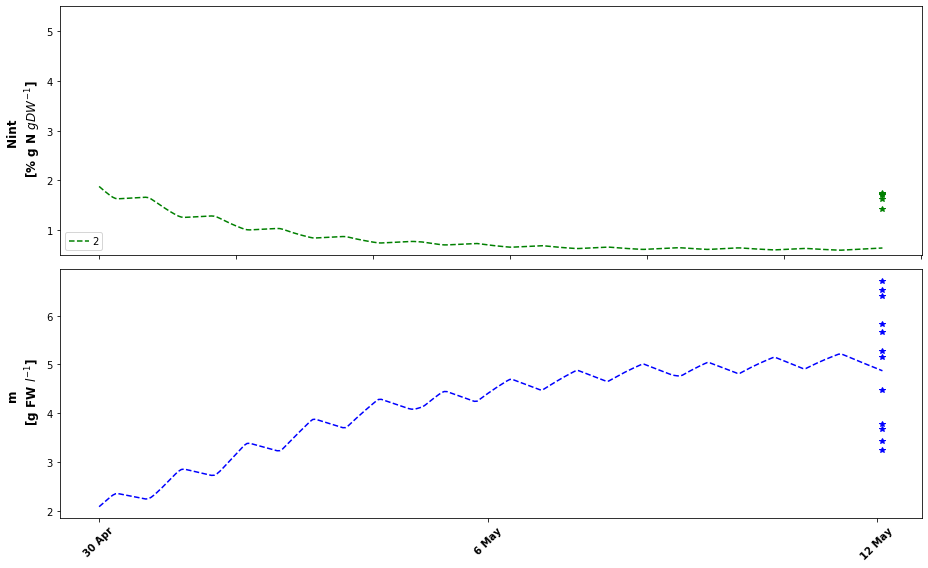

In [33]:
#Offshore plots - exp #4 till 18.12, only background Next (0.8)

mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
mSRE3, NintSRE3 = [], []
mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]

Experiments = [2,3,4,5]
xlabels_all = [['22 July','26 July', '29 July'],['30 Oct','3 Nov', '6 Nov'],['11 Dec','14 Dec', '18 Dec'],['30 Apr', '6 May','12 May'],]


#Next_0_all = [1.5,2,5,4]
Next_0 = 0.8

m_0 = (20 / 1.44) * 0.15
Nint_0_all = [1.76, 1.19, 3.03, 1.88] #two last experiments waiting for real data
VA = 1.44 / (0.3 * 0.15) # units: [g DW/ m^2] # A = w*l - conversion from volumetric to areal units
Z = 5 # m - depth of cages in water
for i in Experiments:
    DATA = []
    xlabels = xlabels_all[i-2]
    print('\nExperiment: #' + str(i) + '\n')

    df4Temp = df4Reduced[(df4Reduced.Exp == i)] 
    Samples = df4Temp.Sample.values
    Nint_0 = Nint_0_all[i-2]
    #Next_0 = Next_0_all[i-2]
    
    t = np.arange(df4Temp['T'].values[0])
    T1 = '2019,07,22,0,0'
    T2 = df4Temp['Timei']
    T2 = T2.tolist()[0]
    t0 = Time_to_Hours(T1,T2)

    # light function
    I_reduced = I_plot[t0:t0+t[-1]+1]
    #print(I_reduced)
    fI0 = interpolate.interp1d(t, I_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    # T function
    T_reduced = T_average[t0:t0+t[-1]+1] 
    #print(T_reduced)

    fTemp0 = interpolate.interp1d(t, T_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    NEXT, NINT, M, TT = [],[],[],[]
    x0 = [Next_0,Nint_0,m_0]  
    
    # model simulation

    # setup initial conditions

    x = odeint(Offshore_constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                           Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))
        
    NEXT.append(x[: , 0]) #
    NINT.append(x[: , 1]) #
    M.append(x[: , 2])    #
    TT.append(t)

    t_model = np.hstack(TT)
    Next_model = np.hstack(NEXT)
    Nint_model = np.hstack(NINT)
    m_model = np.hstack(M)
    
    
    mmod_all.append(m_model[-1])
    print('Initial Nint is: ' + str(round(Nint_0,3)))
    print('Initial biomass: ' + str(round(m_0,3)))
    print('Modeled biomass for Exp ' + str(i) + ': ' + str(round(float(mmod_all[-1]),3)))
    Nintmod_all.append(Nint_model[-1])
    print('Modeled Nint for Exp ' + str(i) + ': ' + str(round(float(Nintmod_all[-1]),3)))
    print('Modeled Next: ' + str(round(float(Next_model[-1]),3)) + '\n')
    
    # plot I and T
    fig2, ax2 = plt.subplots(2,1,figsize=(13,6))
    ax2[0].plot(t,T_reduced,'.',markersize=3,color='black')
    ax2[1].plot(t,I_reduced,'.',markersize=3,color='k')

    ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
    ax2[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")

    ax2[0].set_xticklabels([])
    ax2[1].set_xticklabels([])
    ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")
    
    # plot model
    fig, ax = plt.subplots(2,1,figsize=(13,8))
    ax[0].plot(t,NINT[-1],linestyle = '--',markersize=3.5,color='green')
    ax[0].set_ylim([0.5,5.5])
    ax[1].plot(t,M[-1],linestyle = '--',markersize=3.5,color='blue')

    #col = len(l)
    ax[0].legend(Experiments,loc='lower left',fontsize='medium',markerscale=2,columnspacing = 0.2,handletextpad = 0.3)#,edgecolor='white')
        
    mexp_Temp,Nintexp_Temp = [],[]
    for j in Samples:
        
        print('\nSample: #' + str(math.floor(j)))
        mexp = df4Temp[df4Temp.Sample == j].DW
        mexp = mexp.tolist()[0]
        mexp_Temp.append(mexp)
        Nintexp = df4Temp[df4Temp.Sample == j].N
        Nintexp = Nintexp.tolist()[0]
        Nintexp_Temp.append(Nintexp)
        print('Measured biomass: ' + str(round(mexp,3)))
        print('Measured Nint: ' + str(round(Nintexp,3)) + "\n")      
        
        mSRE3Exp.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
        NintSRE3Exp.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)       
        print('The Sqaure Relative Error for biomass is: ' + str(round(mSRE3Exp[-1],3)))
        print('The Sqaure Relative Error for Nint is: ' + str(round(NintSRE3Exp[-1],3)))
        ax[1].plot(t[-1],mexp,'*',markersize = 6,color='blue')
        ax[0].plot(t[-1],Nintexp,'*',markersize = 6,color='green')

    
    data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
    DATA.append(data)
    #ax[1].plot(t[-1],mexp_Temp[k-1][j],'*',markersize = 6,color=color)
    #ax[0].plot(t[-1],Nintexp_Temp[k-1][j],'*',markersize = 6,color=color)
    
    ax[0].set_xticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

    ax[0].set_ylabel('Nint \n [% g N $g DW^{-1}$]',fontsize=12, weight="bold")
    ax[1].set_ylabel('m \n [g FW $l^{-1}$]',fontsize=12, weight="bold")

    plt.tight_layout()
    
mSRE3All.append(mSRE3Exp)
NintSRE3All.append(NintSRE3Exp)
#mSRE3Exp,NintSRE3Exp = [],[]
    

RMSREm3 = round((np.mean(mSRE3All))**0.5,3)
cleanedNintSRE3 = [x for x in NintSRE3All[0] if str(x) != 'nan']
#print(cleanedNintSRE3)
RMSRENint3 = round((np.mean(cleanedNintSRE3))**0.5,3)


#RMSRENint2 = round((np.mean(cleanedNintSRE2))**0.5,3)
print('\nThe RMSRE of m in the offshore system is: ' + str(RMSREm3))
print('The RMSRE of Nint in the offshore system is: ' + str(RMSRENint3))


Experiment: #2

Initial Nint is: 1.76
Initial biomass: 2.083
Modeled biomass for Exp 2: 2.623
Modeled Nint for Exp 2: 0.653
Modeled Next: 0.5


Sample: #53
Measured biomass: 3.229
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.053
The Sqaure Relative Error for Nint is: nan

Sample: #54
Measured biomass: 4.646
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.595
The Sqaure Relative Error for Nint is: nan

Sample: #55
Measured biomass: 4.885
Measured Nint: 0.902

The Sqaure Relative Error for biomass is: 0.744
The Sqaure Relative Error for Nint is: 0.145

Sample: #56
Measured biomass: 3.937
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.251
The Sqaure Relative Error for Nint is: nan

Sample: #57
Measured biomass: 3.99
Measured Nint: nan

The Sqaure Relative Error for biomass is: 0.272
The Sqaure Relative Error for Nint is: nan

Sample: #58
Measured biomass: 3.615
Measured Nint: 0.762

The Sqaure Relative Error for biomass is: 0.143
The Sq

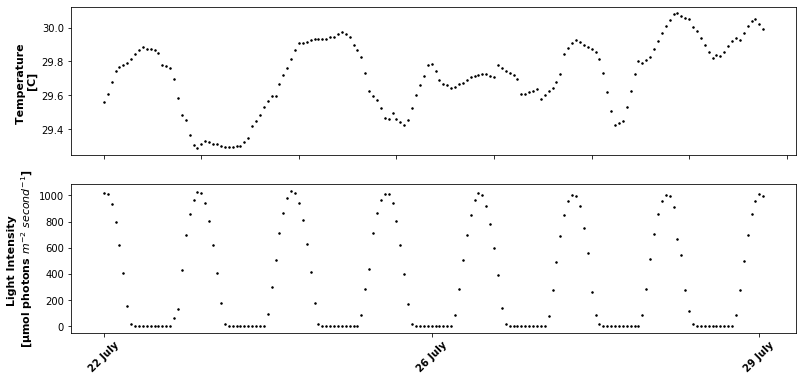

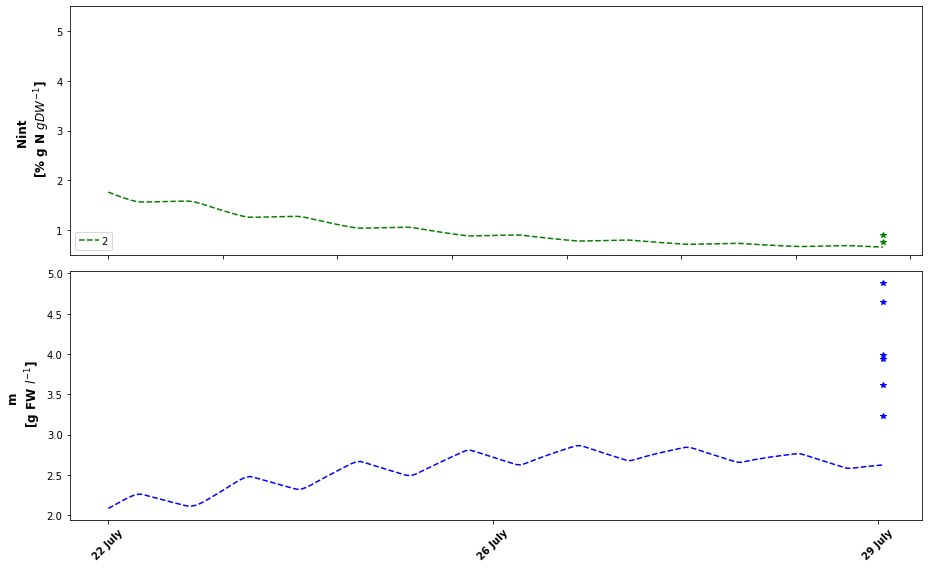

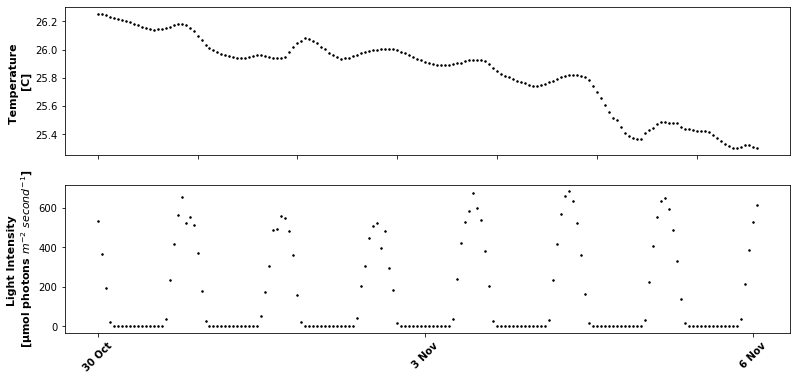

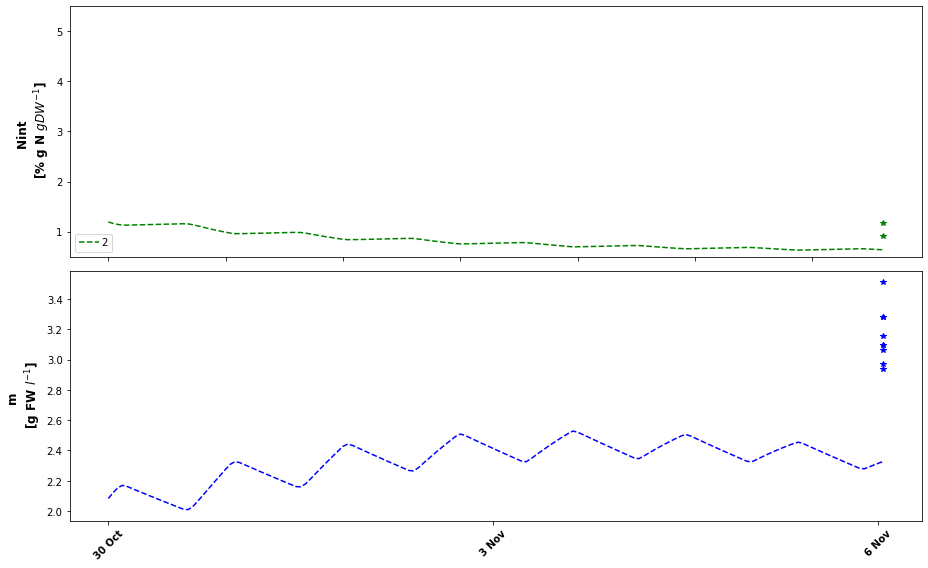

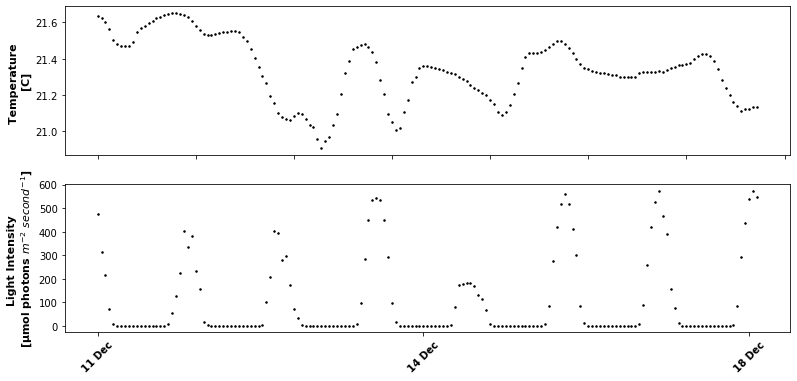

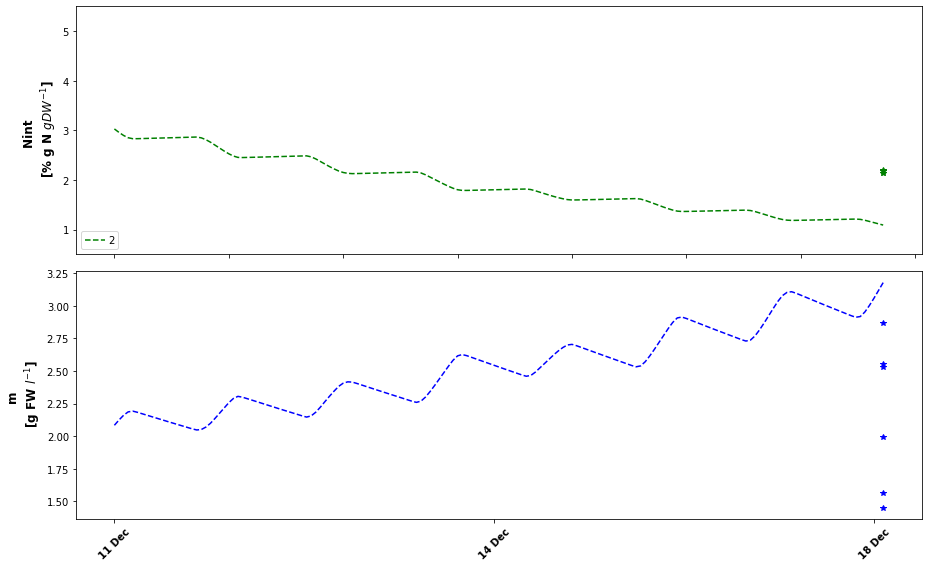

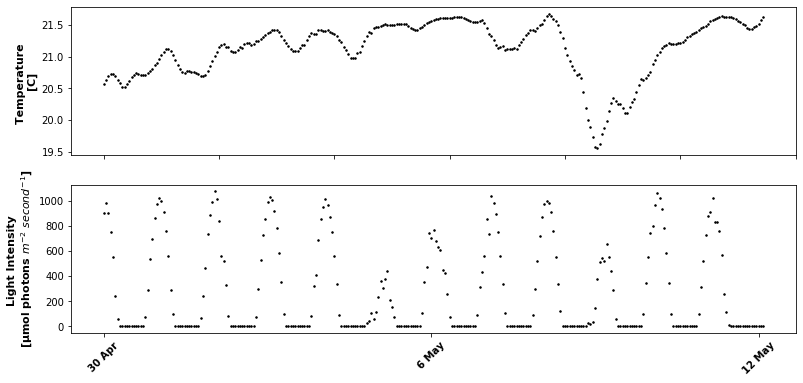

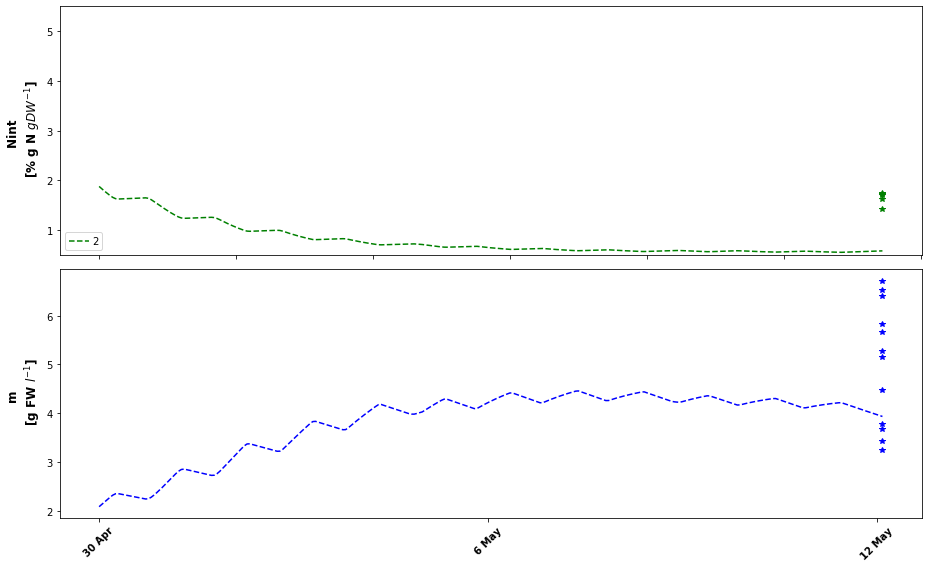

In [34]:
#Offshore plots - exp #4 till 18.12, only background Next (0.5)

mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
mSRE3, NintSRE3 = [], []
mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]

Experiments = [2,3,4,5]
xlabels_all = [['22 July','26 July', '29 July'],['30 Oct','3 Nov', '6 Nov'],['11 Dec','14 Dec', '18 Dec'],['30 Apr', '6 May','12 May'],]


#Next_0_all = [1.5,2,5,4]
Next_0 = 0.5

m_0 = (20 / 1.44) * 0.15
Nint_0_all = [1.76, 1.19, 3.03, 1.88] #two last experiments waiting for real data
VA = 1.44 / (0.3 * 0.15) # units: [g DW/ m^2] # A = w*l - conversion from volumetric to areal units
Z = 5 # m - depth of cages in water
for i in Experiments:
    DATA = []
    xlabels = xlabels_all[i-2]
    print('\nExperiment: #' + str(i) + '\n')

    df4Temp = df4Reduced[(df4Reduced.Exp == i)] 
    Samples = df4Temp.Sample.values
    Nint_0 = Nint_0_all[i-2]
    #Next_0 = Next_0_all[i-2]
    
    t = np.arange(df4Temp['T'].values[0])
    T1 = '2019,07,22,0,0'
    T2 = df4Temp['Timei']
    T2 = T2.tolist()[0]
    t0 = Time_to_Hours(T1,T2)

    # light function
    I_reduced = I_plot[t0:t0+t[-1]+1]
    #print(I_reduced)
    fI0 = interpolate.interp1d(t, I_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    # T function
    T_reduced = T_average[t0:t0+t[-1]+1] 
    #print(T_reduced)

    fTemp0 = interpolate.interp1d(t, T_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")
    
    NEXT, NINT, M, TT = [],[],[],[]
    x0 = [Next_0,Nint_0,m_0]  
    
    # model simulation

    # setup initial conditions

    x = odeint(Offshore_constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                           Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))
        
    NEXT.append(x[: , 0]) #
    NINT.append(x[: , 1]) #
    M.append(x[: , 2])    #
    TT.append(t)

    t_model = np.hstack(TT)
    Next_model = np.hstack(NEXT)
    Nint_model = np.hstack(NINT)
    m_model = np.hstack(M)
    
    
    mmod_all.append(m_model[-1])
    print('Initial Nint is: ' + str(round(Nint_0,3)))
    print('Initial biomass: ' + str(round(m_0,3)))
    print('Modeled biomass for Exp ' + str(i) + ': ' + str(round(float(mmod_all[-1]),3)))
    Nintmod_all.append(Nint_model[-1])
    print('Modeled Nint for Exp ' + str(i) + ': ' + str(round(float(Nintmod_all[-1]),3)))
    print('Modeled Next: ' + str(round(float(Next_model[-1]),3)) + '\n')
    
    # plot I and T
    fig2, ax2 = plt.subplots(2,1,figsize=(13,6))
    ax2[0].plot(t,T_reduced,'.',markersize=3,color='black')
    ax2[1].plot(t,I_reduced,'.',markersize=3,color='k')

    ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
    ax2[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")

    ax2[0].set_xticklabels([])
    ax2[1].set_xticklabels([])
    ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")
    
    # plot model
    fig, ax = plt.subplots(2,1,figsize=(13,8))
    ax[0].plot(t,NINT[-1],linestyle = '--',markersize=3.5,color='green')
    ax[0].set_ylim([0.5,5.5])
    ax[1].plot(t,M[-1],linestyle = '--',markersize=3.5,color='blue')

    #col = len(l)
    ax[0].legend(Experiments,loc='lower left',fontsize='medium',markerscale=2,columnspacing = 0.2,handletextpad = 0.3)#,edgecolor='white')
        
    mexp_Temp,Nintexp_Temp = [],[]
    for j in Samples:
        
        print('\nSample: #' + str(math.floor(j)))
        mexp = df4Temp[df4Temp.Sample == j].DW
        mexp = mexp.tolist()[0]
        mexp_Temp.append(mexp)
        Nintexp = df4Temp[df4Temp.Sample == j].N
        Nintexp = Nintexp.tolist()[0]
        Nintexp_Temp.append(Nintexp)
        print('Measured biomass: ' + str(round(mexp,3)))
        print('Measured Nint: ' + str(round(Nintexp,3)) + "\n")      
        
        mSRE3Exp.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
        NintSRE3Exp.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)       
        print('The Sqaure Relative Error for biomass is: ' + str(round(mSRE3Exp[-1],3)))
        print('The Sqaure Relative Error for Nint is: ' + str(round(NintSRE3Exp[-1],3)))
        ax[1].plot(t[-1],mexp,'*',markersize = 6,color='blue')
        ax[0].plot(t[-1],Nintexp,'*',markersize = 6,color='green')

    
    data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
    DATA.append(data)
    #ax[1].plot(t[-1],mexp_Temp[k-1][j],'*',markersize = 6,color=color)
    #ax[0].plot(t[-1],Nintexp_Temp[k-1][j],'*',markersize = 6,color=color)
    
    ax[0].set_xticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
    ax[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

    ax[0].set_ylabel('Nint \n [% g N $g DW^{-1}$]',fontsize=12, weight="bold")
    ax[1].set_ylabel('m \n [g FW $l^{-1}$]',fontsize=12, weight="bold")

    plt.tight_layout()
    
mSRE3All.append(mSRE3Exp)
NintSRE3All.append(NintSRE3Exp)
#mSRE3Exp,NintSRE3Exp = [],[]
    

RMSREm3 = round((np.mean(mSRE3All))**0.5,3)
cleanedNintSRE3 = [x for x in NintSRE3All[0] if str(x) != 'nan']
#print(cleanedNintSRE3)
RMSRENint3 = round((np.mean(cleanedNintSRE3))**0.5,3)


#RMSRENint2 = round((np.mean(cleanedNintSRE2))**0.5,3)
print('\nThe RMSRE of m in the offshore system is: ' + str(RMSREm3))
print('The RMSRE of Nint in the offshore system is: ' + str(RMSRENint3))

In [35]:
#   c. Offshore system
    # I. Produce an array ("m/Nint_mod") of all model results for final m value (depends time, light, T and more) - done by runing the model in a loop
    # *requires model function wit constant Next
    # II. Add relevant columns from df3_temp and the model results to a new df_combined

In [36]:
# 5. Calculate SRE for m, Nint and Next in DF_combined

In [37]:
# Biomass model error of calibration data

print(RMSREm3)
#0.42
#0.394

0.429


In [38]:
# Biomass model error of calibration data

print(RMSRENint3)
#0.258
#0.198

1.289


In [39]:
#Offshore plots - currents related

mmod_all,mSRE3Exp,Nintmod_all,NintSRE3Exp = [],[],[],[]
mSRE3, NintSRE3 = [], []
mmodAll, mSRE3All, NintmodAll, NintSRE3All = [],[],[],[]
Y1, Y2 = [],[]
Experiments = [2,3,4,5]
xlabels_all = [['22 July','26 July', '29 July'],['30 Oct','3 Nov', '6 Nov'],['11 Dec','17 Dec', '23 Dec'],['30 Apr', '6 May','12 May'],]
Next_0 = 0.5

Next_0_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]
#Next_0_all = []
m_0 = (20 / 1.44) * 0.15
Nint_0_all = [1.76, 1.19, 3.03, 1.88] 
VA = 1.44 / (0.3 * 0.15) # units: [g DW/ m^2] # A = w*l - conversion from volumetric to areal units
Z = 5 # m - depth of cages in water

for i in Experiments:
    All_RMSREm3,All_RMSRENint3 = [],[]
    for k in Next_0_range:
        mSRE3Exp,NintSRE3Exp = [],[]
        Next_0 = k
        DATA = []
        xlabels = xlabels_all[i-2]
        #print('\nExperiment: #' + str(i) + '\n')

        df4Temp = df4Reduced[(df4Reduced.Exp == i)] 
        Samples = df4Temp.Sample.values
        Nint_0 = Nint_0_all[i-2]
        #Next_0 = Next_0_all[i-2]

        t = np.arange(df4Temp['T'].values[0])
        T1 = '2019,07,22,0,0'
        T2 = df4Temp['Timei']
        T2 = T2.tolist()[0]
        t0 = Time_to_Hours(T1,T2)

        # light function
        I_reduced = I_plot[t0:t0+t[-1]+1]
        #print(I_reduced)
        fI0 = interpolate.interp1d(t, I_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")

        # T function
        T_reduced = T_average[t0:t0+t[-1]+1] 
        #print(T_reduced)

        fTemp0 = interpolate.interp1d(t, T_reduced,kind = 'linear', bounds_error=False, fill_value="extrapolate")

        NEXT, NINT, M, TT = [],[],[],[]
        x0 = [Next_0,Nint_0,m_0]  

        # model simulation

        # setup initial conditions

        x = odeint(Offshore_constant_N_new,x0,t,args=(Nintmax,Nintmin,Vmax,Ks,dNextoutdt,dNextindt,miu,dmoutdt,Nintcrit,Sopt,Z,KI,K0,Ka,
                                               Topt,Tmin,Tmax,losses20,teta,Sopt,Smin,Smax,n,umol_to_percent_DW,fTemp0,fI0,VA))

        NEXT.append(x[: , 0]) #
        NINT.append(x[: , 1]) #
        M.append(x[: , 2])    #
        TT.append(t)

        t_model = np.hstack(TT)
        Next_model = np.hstack(NEXT)
        Nint_model = np.hstack(NINT)
        m_model = np.hstack(M)


        mmod_all.append(m_model[-1])
        #print('Initial Nint is: ' + str(round(Nint_0,3)))
        #print('Initial biomass: ' + str(round(m_0,3)))
        #print('Modeled biomass for Exp ' + str(i) + ': ' + str(round(float(mmod_all[-1]),3)))
        Nintmod_all.append(Nint_model[-1])
        #print('Modeled Nint for Exp ' + str(i) + ': ' + str(round(float(Nintmod_all[-1]),3)))
        #print('Modeled Next: ' + str(round(float(Next_model[-1]),3)) + '\n')

        # plot I and T
        #fig2, ax2 = plt.subplots(2,1,figsize=(13,6))
        #ax2[0].plot(t,T_reduced,'.',markersize=3,color='black')
        #ax2[1].plot(t,I_reduced,'.',markersize=3,color='k')

        #ax2[0].set_ylabel('Temperature \n[C]',fontsize=11, weight="bold")
        #ax2[1].set_ylabel('Light Intensity \n[µmol photons $m^{-2}$ $second^{-1}$]',fontsize=11, weight="bold")

        #ax2[0].set_xticklabels([])
        #ax2[1].set_xticklabels([])
        #ax2[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
        #ax2[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

        # plot model
        #fig, ax = plt.subplots(2,1,figsize=(13,8))
        #ax[0].plot(t,NINT[-1],linestyle = '--',markersize=3.5,color='green')
        #ax[0].set_ylim([0.5,5.5])
        #ax[1].plot(t,M[-1],linestyle = '--',markersize=3.5,color='blue')

        #col = len(l)
        #ax[0].legend(Experiments,loc='lower left',fontsize='medium',markerscale=2,columnspacing = 0.2,handletextpad = 0.3)#,edgecolor='white')

        mexp_Temp,Nintexp_Temp = [],[]
        for j in Samples:

            #print('\nSample: #' + str(math.floor(j)))
            mexp = df4Temp[df4Temp.Sample == j].DW
            mexp = mexp.tolist()[0]
            mexp_Temp.append(mexp)
            Nintexp = df4Temp[df4Temp.Sample == j].N
            Nintexp = Nintexp.tolist()[0]
            Nintexp_Temp.append(Nintexp)
            #print('Measured biomass: ' + str(round(mexp,3)))
            #print('Measured Nint: ' + str(round(Nintexp,3)) + "\n")      

            mSRE3Exp.append(((mexp-mmod_all[-1])/mmod_all[-1])**2)
            NintSRE3Exp.append(((Nintexp-Nintmod_all[-1])/Nintmod_all[-1])**2)       
            #print('The Sqaure Relative Error for biomass is: ' + str(round(mSRE3Exp[-1],3)))
            #print('The Sqaure Relative Error for Nint is: ' + str(round(NintSRE3Exp[-1],3)))
            #ax[1].plot(t[-1],mexp,'*',markersize = 6,color='blue')
            #ax[0].plot(t[-1],Nintexp,'*',markersize = 6,color='green')


        data = {'T':T[0],'Next':NEXT[0],'Nint':NINT[0],'m':M[0]}
        DATA.append(data)
        #ax[1].plot(t[-1],mexp_Temp[k-1][j],'*',markersize = 6,color=color)
        #ax[0].plot(t[-1],Nintexp_Temp[k-1][j],'*',markersize = 6,color=color)

        #ax[0].set_xticklabels([])
        #ax[1].set_xticklabels([])
        #ax[1].set_xticks(t[0:len(t):int(len(t)/2-1)])
        #ax[1].set_xticklabels([str(i) for i in xlabels], rotation=45,fontsize=10, weight="bold")

        #ax[0].set_ylabel('Nint \n [% g N $g DW^{-1}$]',fontsize=12, weight="bold")
        #ax[1].set_ylabel('m \n [g FW $l^{-1}$]',fontsize=12, weight="bold")

        #plt.tight_layout()

        mSRE3All.append(mSRE3Exp)
        NintSRE3All.append(NintSRE3Exp)
        #mSRE3Exp,NintSRE3Exp = [],[]
    

        RMSREm3 = round((np.mean(mSRE3Exp))**0.5,3)
        cleanedNintSRE3 = [x for x in NintSRE3Exp if str(x) != 'nan']
        #print(cleanedNintSRE3)
        RMSRENint3 = round((np.mean(cleanedNintSRE3))**0.5,3)
        All_RMSREm3.append(RMSREm3)
        All_RMSRENint3.append(RMSRENint3)
    Y1.append(All_RMSREm3)
    Y2.append(All_RMSRENint3)
    print(i)

#RMSRENint2 = round((np.mean(cleanedNintSRE2))**0.5,3)
#print('\nThe RMSRE of m in the offshore system is: ' + str(RMSREm3))
#print('The RMSRE of Nint in the offshore system is: ' + str(RMSRENint3))

2
3
4
5
